In [ ]:
#Mess of a notebook including examples of training in the first stage of experiments on FMNIST
#Also includes creating heatmaps and applying temperature scaling to a bunch of weight files

In [ ]:
import copy
import os
import random
import time

import keras.backend as K
import numpy as np
import sklearn.metrics as metrics
import tensorflow as tf
from keras import Input, Model, optimizers, callbacks
from keras.activations import softmax as keras_softmax
from keras.callbacks import Callback
from keras.layers import (Dense, Activation, Flatten, Lambda, Convolution2D, AveragePooling2D, BatchNormalization, Add)
from keras.regularizers import l2
from keras.utils import np_utils
from sklearn.metrics import log_loss, brier_score_loss
from tensorflow import keras

In [ ]:
os.environ['PYTHONHASHSEED']=str(0)
random.seed(0)
np.random.seed(0)
os.environ['TF_DETERMINISTIC_OPS'] = '1'

In [ ]:
import csv

def write_metrics_to_csv(filename, error, ece, mce, log_loss, brier):
    with open(filename, 'a', newline='') as csvfile:
        fieldnames = ['error', 'ece', 'mce', 'log_loss', 'brier']
        writer = csv.DictWriter(csvfile, fieldnames=fieldnames)

        # Write header only if the file is empty
        if csvfile.tell() == 0:
            writer.writeheader()

        writer.writerow({
            'error': error,
            'ece': ece,
            'mce': mce,
            'log_loss': log_loss,
            'brier': brier
        })
def write_mean_and_std_to_csv(filename, model_name, value_names, mean, std_dev):
    with open(filename, 'a', newline='') as csvfile:
        fieldnames = ['model_name'] + [f'{name}_mean' for name in value_names] + [f'{name}_std_dev' for name in value_names]
        writer = csv.DictWriter(csvfile, fieldnames=fieldnames)

        # Write header only if the file is empty
        if csvfile.tell() == 0:
            writer.writeheader()

        row_dict = {'model_name': model_name}
        row_dict.update({f'{name}_mean': mean_value for name, mean_value in zip(value_names, mean)})
        row_dict.update({f'{name}_std_dev': std_dev_value for name, std_dev_value in zip(value_names, std_dev)})
        writer.writerow(row_dict)

In [ ]:
def _get_p_survival(block=0, nb_total_blocks=110, p_survival_end=0.5, mode='linear_decay'):
    """
    See eq. (4) in stochastic depth paper: http://arxiv.org/pdf/1603.09382v1.pdf
    """
    if mode == 'uniform':
        return p_survival_end
    elif mode == 'linear_decay':
        return 1 - ((block + 1) / nb_total_blocks) * (1 - p_survival_end)
    else:
        raise

            
def _zero_pad_channels(x, pad=0):
    """
    Function for Lambda layer
    """
    pattern = [[0, 0], [0, 0], [0, 0], [pad - pad // 2, pad // 2]]
    return tf.pad(x, pattern)


def _stochastic_survival(y, p_survival=1.0):
    # binomial random variable
    survival = K.random_bernoulli((1,), p=p_survival)
    # during testing phase:
    # - scale y (see eq. (6))
    # - p_survival effectively becomes 1 for all layers (no layer dropout)
    return K.in_test_phase(tf.constant(p_survival, dtype='float32') * y, 
                           survival * y)


def _stochastic_depth_residual_block(x, nb_filters=16, block=0, nb_total_blocks=110, subsample_factor=1, weight_decay = 0.0001):
    """
    Stochastic depth paper: http://arxiv.org/pdf/1603.09382v1.pdf
    
    Residual block consisting of:
    - Conv - BN - ReLU - Conv - BN
    - identity shortcut connection
    - merge Conv path with shortcut path

    Original paper (http://arxiv.org/pdf/1512.03385v1.pdf) then has ReLU,
    but we leave this out: see https://github.com/gcr/torch-residual-networks

    Additional variants explored in http://arxiv.org/pdf/1603.05027v1.pdf
    
    some code adapted from https://github.com/dblN/stochastic_depth_keras
    """
    
    prev_nb_channels = K.int_shape(x)[3]

    if subsample_factor > 1:
        subsample = (subsample_factor, subsample_factor)
        # shortcut: subsample + zero-pad channel dim
        shortcut = AveragePooling2D(pool_size=subsample, data_format="channels_last")(x)
        if nb_filters > prev_nb_channels:
            shortcut = Lambda(_zero_pad_channels,
                              arguments={'pad': nb_filters - prev_nb_channels})(shortcut)
    else:
        subsample = (1, 1)
        # shortcut: identity
        shortcut = x

    y = Convolution2D(nb_filters, (3, 3), strides=subsample, 
                      padding="same", data_format="channels_last", 
                      kernel_initializer="he_normal",
                      kernel_regularizer=l2(weight_decay))(x)
    y = BatchNormalization(axis=3)(y)
    y = Activation('relu')(y)
    y = Convolution2D(nb_filters, (3, 3), strides=(1, 1), 
                      padding="same", data_format="channels_last", 
                      kernel_initializer="he_normal",
                      kernel_regularizer=l2(weight_decay))(y)
    y = BatchNormalization(axis=3)(y)
    
    p_survival = _get_p_survival(block=block, nb_total_blocks=nb_total_blocks, p_survival_end=0.5, mode='linear_decay')
    y = Lambda(_stochastic_survival, arguments={'p_survival': p_survival})(y)
    
    out = Add()([y, shortcut])

    return out

def resnet_sd_model(img_shape = (32,32), img_channels = 3, layers = 110, nb_classes = 10, verbose = False, weight_decay = 0.0001):

    start_time = time.time()  # Take time

    img_rows, img_cols = img_shape
    blocks_per_group = (layers - 2)//6
    
    if verbose:
        print("Blocks per group:", blocks_per_group)

    inputs = Input(shape=(img_rows, img_cols, img_channels))

    # Create model
    x = Convolution2D(16, (3, 3), padding="same", data_format="channels_last", 
                      kernel_initializer="he_normal", kernel_regularizer=l2(weight_decay))(inputs)
    x = BatchNormalization(axis=3)(x)
    x = Activation('relu')(x)

    # 1st group
    for i in range(0, blocks_per_group):
        nb_filters = 16
        x = _stochastic_depth_residual_block(x, nb_filters=nb_filters, 
                                            block=i, nb_total_blocks=3 * blocks_per_group, 
                                            subsample_factor=1)

    # 2nd group
    for i in range(0, blocks_per_group):
        nb_filters = 32
        if i == 0:
            subsample_factor = 2
        else:
            subsample_factor = 1
        x = _stochastic_depth_residual_block(x, nb_filters=nb_filters, 
                                            block=blocks_per_group + i, nb_total_blocks=3 * blocks_per_group, 
                                            subsample_factor=subsample_factor, weight_decay = weight_decay)
    # 3rd group
    for i in range(0, blocks_per_group):
        nb_filters = 64
        if i == 0:
            subsample_factor = 2
        else:
            subsample_factor = 1
        x = _stochastic_depth_residual_block(x, nb_filters=nb_filters, 
                                            block=2 * blocks_per_group + i, nb_total_blocks=3 * blocks_per_group, 
                                            subsample_factor=subsample_factor, weight_decay = weight_decay)

    x = AveragePooling2D(pool_size=(7, 7), strides=None, padding='valid', data_format="channels_last")(x)
    x = Flatten()(x)
#pool_size=(2, 2), 
    predictions = Dense(nb_classes, activation='softmax')(x)

    model = Model(inputs=inputs, outputs=predictions)

    if verbose:
        model.summary()
        
    return model

In [ ]:
import numpy as np
import keras
from keras.datasets import fashion_mnist
from sklearn.model_selection import train_test_split

def color_preprocessing(x_train, x_val, x_test):
    x_train = x_train.astype('float32')
    x_val = x_val.astype('float32')
    x_test = x_test.astype('float32')

    # Handle grayscale images with a single channel
    axis = (0, 1, 2) if x_train.ndim == 4 else (0, 1)

    mean = np.mean(x_train, axis=axis)  # Per channel mean
    std = np.std(x_train, axis=axis)
    x_train = (x_train - mean) / std
    x_val = (x_val - mean) / std
    x_test = (x_test - mean) / std

    return x_train, x_val, x_test

learning_rate = 0.1
nb_epochs = 50
batch_size = 128
num_classes = 10
seed = 333
layers = 152  

(x_train, y_train), (x_test, y_test) = fashion_mnist.load_data()

# Add a channel dimension to grayscale images
x_train = x_train.reshape(x_train.shape[0], 28, 28, 1)
x_test = x_test.reshape(x_test.shape[0], 28, 28, 1)



x_train45, x_val, y_train45, y_val = train_test_split(x_train, y_train, test_size=0.9,
                                                      random_state=seed)  # random_state = seed
x_train45, x_val, x_test = color_preprocessing(x_train45, x_val, x_test)

y_train45 = keras.utils.to_categorical(y_train45, num_classes)
y_val = keras.utils.to_categorical(y_val, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)
    
# building and training net
model = resnet_sd_model(img_shape = (28,28), img_channels = 1, 
                        layers = layers, nb_classes = num_classes, verbose = False)

In [ ]:
def plot_losses(train_losses, test_losses, ece_scores, mce_scores, log_losses, brier_scores):
    epochs = []
    for i in range(1,len(train_losses)+1):
      epochs.append(i)

    fig, axs = plt.subplots(2, 2, figsize=(12, 10))
    axs[0, 0].plot(epochs, train_losses, 'r', label='Treeningandmete täpsus')
    axs[0, 0].plot(epochs, test_losses, 'b', label='Testandmete täpsus')
    axs[0, 0].set_title('Treening- ja testandmete täpsus')
    axs[0, 0].set_xlabel('Epohhid')
    axs[0, 0].set_ylabel('Väärtus')
    axs[0, 0].legend()

    axs[0, 1].plot(epochs, ece_scores, 'g', label='ECE')
    axs[0, 1].set_title('ECE')
    axs[0, 1].set_xlabel('Epohhid')
    axs[0, 1].set_ylabel('ECE')
    axs[0, 1].legend()

    axs[1, 0].plot(epochs, mce_scores, 'c', label='MCE')
    axs[1, 0].set_title('MCE')
    axs[1, 0].set_xlabel('Epohhid')
    axs[1, 0].set_ylabel('MCE')
    axs[1, 0].legend()

    axs[1, 1].plot(epochs, log_losses, 'm', label='NLL')
    axs[1, 1].set_title('NLL')
    axs[1, 1].set_xlabel('Epohhid')
    axs[1, 1].set_ylabel('Väärtus')
    axs[1, 1].legend()

    plt.tight_layout()
    plt.show()

class TestAndTrainLossTracker(Callback):
    def __init__(self, test_data, model_eval,initial_epoch, start_tracking_epoch=1):
        self.test_data = test_data
        self.train_losses = []
        self.test_losses = []
        self.ece_scores = []
        self.mce_scores = []
        self.log_losses = []
        self.brier_scores = []
        self.initial_epoch = initial_epoch
        self.model_eval = model_eval
        self.start_tracking_epoch = start_tracking_epoch

    def on_epoch_end(self, epoch, logs=None):
        logs = logs or {}
        global_epoch = self.initial_epoch + epoch
        if global_epoch >= self.start_tracking_epoch:
            x_test, y_test = self.test_data
            test_loss,test_acc = self.model.evaluate(x_test, y_test, verbose=0)
            weights_temp_file = "temp.h5"
            self.model.save(weights_temp_file)
            error, ece, mce, loss, brier = evaluate(self.model_eval,weights_temp_file,x_test,y_test,bins=15,verbose=False)
            train_acc = float(logs["accuracy"])
            self.train_losses.append(train_acc)
            self.test_losses.append(test_acc)
            self.ece_scores.append(ece)
            self.mce_scores.append(mce)
            self.log_losses.append(loss)
            self.brier_scores.append(brier)


def compute_acc_bin(conf_thresh_lower, conf_thresh_upper, conf, pred, true):
    """
    # Computes accuracy and average confidence for bin

    Args:
        conf_thresh_lower (float): Lower Threshold of confidence interval
        conf_thresh_upper (float): Upper Threshold of confidence interval
        conf (numpy.ndarray): list of confidences
        pred (numpy.ndarray): list of predictions
        true (numpy.ndarray): list of true labels

    Returns:
        (accuracy, avg_conf, len_bin): accuracy of bin, confidence of bin and number of elements in bin.
    """
    filtered_tuples = [x for x in zip(pred, true, conf) if x[2] > conf_thresh_lower and x[2] <= conf_thresh_upper]
    if len(filtered_tuples) < 1:
        return 0, 0, 0
    else:
        correct = len([x for x in filtered_tuples if x[0] == x[1]])  # How many correct labels
        len_bin = len(filtered_tuples)  # How many elements falls into given bin
        avg_conf = sum([x[2] for x in filtered_tuples]) / len_bin  # Avg confidence of BIN
        accuracy = float(correct) / len_bin  # accuracy of BIN
        return accuracy, avg_conf, len_bin


def ECE(conf, pred, true, bin_size=0.1):
    """
    Expected Calibration Error

    Args:
        conf (numpy.ndarray): list of confidences
        pred (numpy.ndarray): list of predictions
        true (numpy.ndarray): list of true labels
        bin_size: (float): size of one bin (0,1)  # TODO should convert to number of bins?

    Returns:
        ece: expected calibration error
    """

    upper_bounds = np.arange(bin_size, 1 + bin_size, bin_size)  # Get bounds of bins

    n = len(conf)
    ece = 0  # Starting error

    for conf_thresh in upper_bounds:  # Go through bounds and find accuracies and confidences
        acc, avg_conf, len_bin = compute_acc_bin(conf_thresh - bin_size, conf_thresh, conf, pred, true)
        ece += np.abs(acc - avg_conf) * len_bin / n  # Add weigthed difference to ECE

    return ece


def MCE(conf, pred, true, bin_size=0.1):
    """
    Maximal Calibration Error

    Args:
        conf (numpy.ndarray): list of confidences
        pred (numpy.ndarray): list of predictions
        true (numpy.ndarray): list of true labels
        bin_size: (float): size of one bin (0,1)  # TODO should convert to number of bins?

    Returns:
        mce: maximum calibration error
    """

    upper_bounds = np.arange(bin_size, 1 + bin_size, bin_size)

    cal_errors = []

    for conf_thresh in upper_bounds:
        acc, avg_conf, _ = compute_acc_bin(conf_thresh - bin_size, conf_thresh, conf, pred, true)
        cal_errors.append(np.abs(acc - avg_conf))

    return max(cal_errors)


def get_bin_info(conf, pred, true, bin_size=0.1):
    """
    Get accuracy, confidence and elements in bin information for all the bins.

    Args:
        conf (numpy.ndarray): list of confidences
        pred (numpy.ndarray): list of predictions
        true (numpy.ndarray): list of true labels
        bin_size: (float): size of one bin (0,1)  # TODO should convert to number of bins?

    Returns:
        (acc, conf, len_bins): tuple containing all the necessary info for reliability diagrams.
    """

    upper_bounds = np.arange(bin_size, 1 + bin_size, bin_size)

    accuracies = []
    confidences = []
    bin_lengths = []

    for conf_thresh in upper_bounds:
        acc, avg_conf, len_bin = compute_acc_bin(conf_thresh - bin_size, conf_thresh, conf, pred, true)
        accuracies.append(acc)
        confidences.append(avg_conf)
        bin_lengths.append(len_bin)

    return accuracies, confidences, bin_lengths


def evaluate(model, weights_file, x_test, y_test, bins=15, verbose=True):
    """
    Evaluate model using various scoring measures: Error Rate, ECE, MCE, NLL, Brier Score

    Params:
        probs: a list containing probabilities for all the classes with a shape of (samples, classes)
        y_true: a list containing the actual class labels
        verbose: (bool) are the scores printed out. (default = False)
        normalize: (bool) in case of 1-vs-K calibration, the probabilities need to be normalized.
        bins: (int) - into how many bins are probabilities divided (default = 15)

    Returns:
        (error, ece, mce, loss, brier), returns various scoring measures
    """
    last_layer = model.layers.pop()
    last_layer.activation = keras.activations.linear
    i = model.input
    o = last_layer(model.layers[-2].output)

    model = keras.models.Model(inputs=i, outputs=[o])

    # First load in the weights
    model.load_weights(weights_file)
    sgd = optimizers.SGD(learning_rate=.1, momentum=0.9, nesterov=True)
    model.compile(optimizer=sgd, loss="categorical_crossentropy")

    # Next get predictions
    y_logits = model.predict(x_test, verbose=1)
    y_logits_tensor = tf.convert_to_tensor(y_logits)  # Convert NumPy array to TensorFlow tensor
    y_probs_tensor = keras_softmax(y_logits_tensor, axis=-1)  # Apply softmax function to the tensor
    probs = y_probs_tensor.numpy()  
    y_true = y_test

    # Confidence of prediction
    confs = np.max(probs, axis=1)  # Take only maximum confidence

    preds = np.argmax(probs, axis=1)  # Take maximum confidence as prediction

    if y_true.shape[1] > 1:  # If 1-hot representation, get back to numeric
        y_true = np.array([[np.where(r == 1)[0][0]] for r in y_true])  # Back to np array also

    accuracy = metrics.accuracy_score(y_true, preds) * 100
    error = 100 - accuracy

    # Calculate ECE
    ece = ECE(confs, preds, y_true, bin_size=1 / bins)
    # Calculate MCE
    mce = MCE(confs, preds, y_true, bin_size=1 / bins)
    loss = log_loss(y_true=y_true, y_pred=probs)
    # Calculate Brier score for each class
    y_prob_true = np.array([probs[i, idx] for i, idx in enumerate(y_true)])
    for i in range(len(y_true)):
      y_true[i] = 1
    brier = brier_score_loss(y_true=y_true, y_prob=y_prob_true)  # Brier Score (MSE)
    if verbose:
        print("Accuracy:", accuracy)
        print("Error:", error)
        print("ECE:", ece)
        print("MCE:", mce)
        print("Loss:", loss)
        print("brier:", brier)

    return error, ece, mce, loss, brier


def lr_scheduler(epoch, lr, lr_schedule, all_epochs):
    current_epoch = all_epochs + epoch
    for start_epoch, new_lr in lr_schedule:
        if current_epoch == start_epoch:
            return new_lr
    return lr

In [ ]:
#add graphs for a training to see some possible patterns
def freezing_with_plot(model, x_train, y_train, x_val, y_val, x_test, y_test, freezing_list, batch_size=128,
             lr_schedule=None, name='lenet_c10'):
    if lr_schedule is None:
        lr_schedule = [[0, 0.001], [25, 0.0001]]
    all_epochs = 0
    total_train_losses = []
    total_test_losses = []
    total_ece_scores = []
    total_mce_scores = []
    total_log_losses = []
    total_brier_scores = []
    model_for_eval = copy.deepcopy(model)
    test_and_train_loss_tracker = TestAndTrainLossTracker(test_data=(x_test, y_test), model_eval=model_for_eval, initial_epoch=all_epochs)
    sgd = optimizers.SGD(learning_rate=.1, momentum=0.9, nesterov=True)
    iterations = len(x_train) // batch_size
    custom_lr_scheduler = callbacks.LearningRateScheduler(lambda epoch, lr: lr_scheduler(epoch, lr, lr_schedule, all_epochs))
    model.compile(loss='categorical_crossentropy', optimizer=sgd, metrics=['accuracy'])
    hist = model.fit(x_train, y_train, batch_size=batch_size,
                     steps_per_epoch=iterations,
                     epochs=freezing_list[0], verbose=1, callbacks=[custom_lr_scheduler,test_and_train_loss_tracker])
    all_epochs += freezing_list[0]
    total_train_losses.extend(test_and_train_loss_tracker.train_losses)
    total_test_losses.extend(test_and_train_loss_tracker.test_losses)
    total_ece_scores.extend(test_and_train_loss_tracker.ece_scores)
    total_mce_scores.extend(test_and_train_loss_tracker.mce_scores)
    total_log_losses.extend(test_and_train_loss_tracker.log_losses)
    total_brier_scores.extend(test_and_train_loss_tracker.brier_scores)
    for i in range(len(freezing_list) - 1):
        model.layers[i].trainable = False
        if freezing_list[i + 1] > freezing_list[i]:
            model.compile(loss='categorical_crossentropy', optimizer=sgd, metrics=['accuracy'])
            test_and_train_loss_tracker = TestAndTrainLossTracker(test_data=(x_test, y_test),model_eval=model_for_eval, initial_epoch=all_epochs)
            hist = model.fit(x_train, y_train, batch_size=batch_size,
                             steps_per_epoch=iterations,
                             epochs=freezing_list[i + 1] - freezing_list[i], verbose=1, callbacks=[custom_lr_scheduler,test_and_train_loss_tracker])
            total_train_losses.extend(test_and_train_loss_tracker.train_losses)
            total_test_losses.extend(test_and_train_loss_tracker.test_losses)
            total_ece_scores.extend(test_and_train_loss_tracker.ece_scores)
            total_mce_scores.extend(test_and_train_loss_tracker.mce_scores)
            total_log_losses.extend(test_and_train_loss_tracker.log_losses)
            total_brier_scores.extend(test_and_train_loss_tracker.brier_scores)
            all_epochs += (freezing_list[i + 1] - freezing_list[i])
            print("Current: ", i)
    file_name = name
    weights_file = file_name + '.h5'
    model.save(weights_file)
    error, ece, mce, loss, brier = evaluate(model_for_eval, weights_file, x_test, y_test, bins=15, verbose=True)
    plot_losses(total_train_losses, total_test_losses,total_ece_scores, total_mce_scores,total_log_losses,total_brier_scores)
    write_metrics_to_csv(file_name + '.csv', error, ece, mce, loss, brier)
    return [error, ece, mce, loss, brier]
#training with freezing method
def freezing(model, x_train, y_train, x_val, y_val, x_test, y_test, freezing_list, batch_size=128,
             lr_schedule=None, name='lenet_c10'):
    if lr_schedule is None:
        lr_schedule = [[0, 0.001], [25, 0.0001]]
    all_epochs = 0
    sgd = optimizers.SGD(learning_rate=.1, momentum=0.9, nesterov=True)
    iterations = len(x_train) // batch_size
    custom_lr_scheduler = callbacks.LearningRateScheduler(lambda epoch, lr: lr_scheduler(epoch, lr, lr_schedule, all_epochs))
    model.compile(loss='categorical_crossentropy', optimizer=sgd, metrics=['accuracy'])
    hist = model.fit(x_train, y_train, batch_size=batch_size,
                     steps_per_epoch=iterations,
                     epochs=freezing_list[0], verbose=0, callbacks=[custom_lr_scheduler])
    all_epochs += freezing_list[0]
    for i in range(len(freezing_list) - 1):
        model.layers[i].trainable = False
        if freezing_list[i + 1] > freezing_list[i]:
            model.compile(loss='categorical_crossentropy', optimizer=sgd, metrics=['accuracy'])
            hist = model.fit(x_train, y_train, batch_size=batch_size,
                             steps_per_epoch=iterations,
                             epochs=freezing_list[i + 1] - freezing_list[i], verbose=0, callbacks=[custom_lr_scheduler])
            all_epochs += (freezing_list[i + 1] - freezing_list[i])
            print("Current: ", i)
    file_name = name
    weights_file = file_name + '.h5'
    model.save(weights_file)
    error, ece, mce, loss, brier = evaluate(model, weights_file, x_test, y_test, bins=15, verbose=True)
    write_metrics_to_csv(file_name + '.csv', error, ece, mce, loss, brier)
    return [error, ece, mce, loss, brier],model
# running freezing according to a seed n times with first including graphs
def freezing_average(times, model, x_train, y_train, x_val, y_val, x_test, y_test, freezing_list, batch_size=128,
                     lr_schedule=None, name='lenet_c10'):
    if lr_schedule is None:
        lr_schedule = [[0, 0.001], [25, 0.0001]]
    results = np.zeros((times, 5))
    for i in range(times):
        tf.random.set_seed(i)
        x = tf.random.uniform((x_test.shape[0] ,28 , 28, 1))
        model(x)
        if i == 0:
          test_results, model = freezing_with_plot(model, x_train, y_train, x_val, y_val, x_test, y_test, freezing_list,
                                batch_size=batch_size,
                                lr_schedule=lr_schedule, name=name)
        else:
          test_results, model = freezing(model, x_train, y_train, x_val, y_val, x_test, y_test, freezing_list,
                                batch_size=batch_size,
                                lr_schedule=lr_schedule, name=name)

        results[i, :] = test_results

    mean = np.mean(results, axis=0)
    std_dev = np.std(results, axis=0, ddof=1)

    value_names = ["Error", "ECE", "MCE", "Log loss", "Brier score"]
    print(name + ", " + str(times))
    for i, (mean_value, std_dev_value) in enumerate(zip(mean, std_dev)):
        print(f"{value_names[i]}: Mean = {mean_value}, Standard Deviation = {std_dev_value}")
    sorted_results = np.sort(results, axis=0)
    reduced_results = sorted_results[2:-2]  # Remove the 2 best and 2 worst results

    mean_reduced = np.mean(reduced_results, axis=0)
    std_dev_reduced = np.std(reduced_results, axis=0, ddof=1)

    value_names = ["Error", "ECE", "MCE", "Log loss", "Brier score"]
    print(name + ", " + str(times))
    for i, (mean_value, std_dev_value) in enumerate(zip(mean_reduced, std_dev_reduced)):
        print(f"{value_names[i]}: Mean Reduced = {mean_value}, Standard Deviation = {std_dev_value}")
    write_mean_and_std_to_csv('mean_and_std_values_full_cifar.csv', name, value_names, mean, std_dev)

    # Call the function for reduced results
    write_mean_and_std_to_csv('fmnist_results_reduced3.csv', name, value_names, mean_reduced, std_dev_reduced)

    return model

In [ ]:
#0.2,0.4,0.6,0.8,0.9
#10,20,30,40,45
freezing_list_rn = []
for i in range(len(model.layers)):
  if i < len(model.layers) * 0.95:
    freezing_list_rn.append(45)
freezing_list_rn.append(50)

Epoch 1/45
46/46 [==============================] - 30s 204ms/step - loss: 2.4546 - accuracy: 0.5659 - lr: 0.0100
Epoch 2/45
46/46 [==============================] - 10s 209ms/step - loss: 1.8684 - accuracy: 0.7270 - lr: 0.0100
Epoch 3/45
46/46 [==============================] - 10s 208ms/step - loss: 1.7234 - accuracy: 0.7769 - lr: 0.0100
Epoch 4/45
46/46 [==============================] - 9s 204ms/step - loss: 1.6453 - accuracy: 0.8110 - lr: 0.0100
Epoch 5/45
46/46 [==============================] - 9s 205ms/step - loss: 1.5912 - accuracy: 0.8282 - lr: 0.0100
Epoch 6/45
46/46 [==============================] - 35s 773ms/step - loss: 1.5652 - accuracy: 0.8386 - lr: 0.0100
Epoch 7/45
46/46 [==============================] - 9s 204ms/step - loss: 1.5495 - accuracy: 0.8440 - lr: 0.0100
Epoch 8/45
46/46 [==============================] - 10s 208ms/step - loss: 1.5197 - accuracy: 0.8535 - lr: 0.0100
Epoch 9/45
46/46 [==============================] - 10s 209ms/step - loss: 1.4988 - accurac

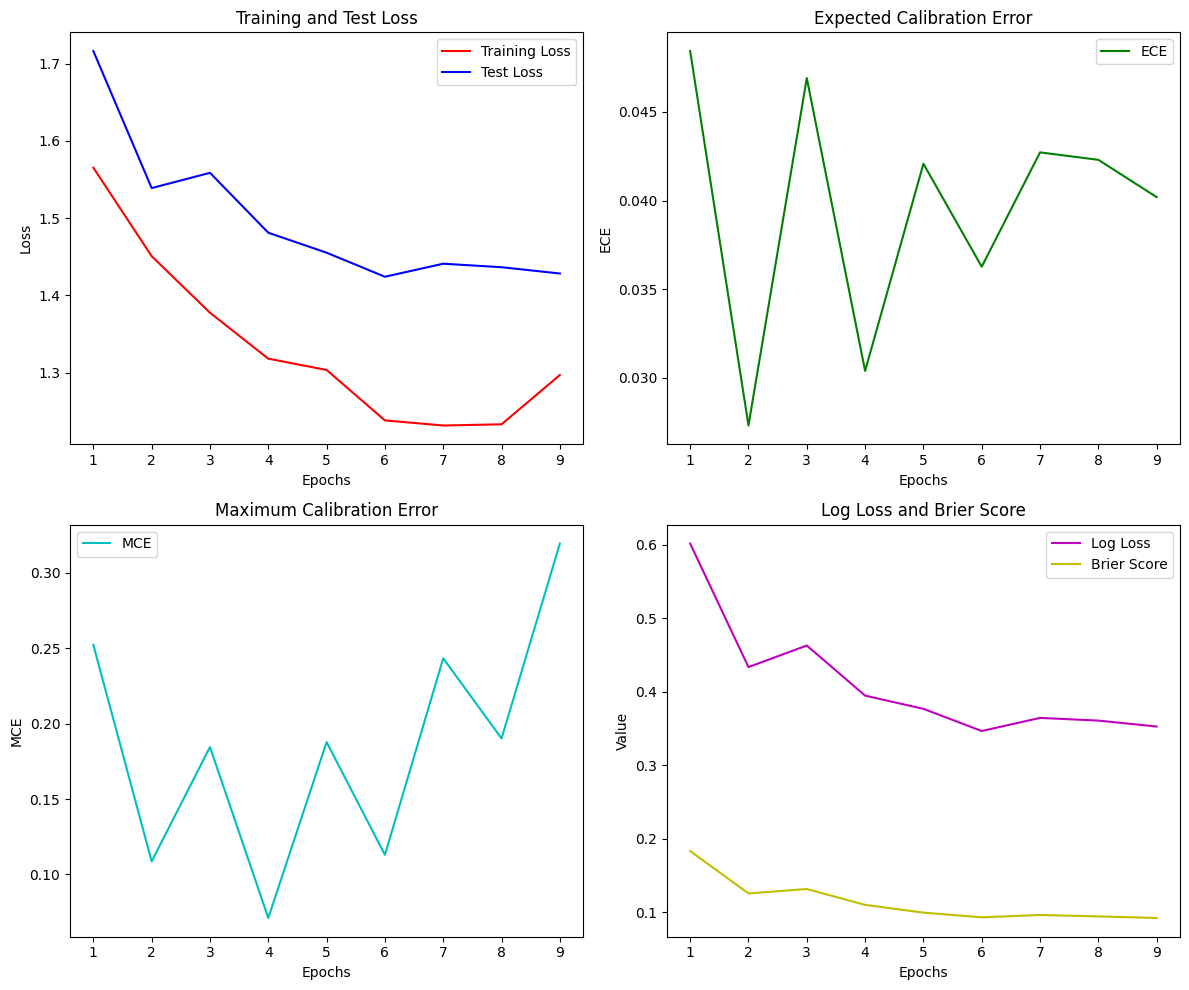

313/313 [==============================] - 10s 17ms/step
Accuracy: 88.84
Error: 11.159999999999997
ECE: 0.03928674813807013
MCE: 0.3120443783700466
Loss: 0.34870353420256817
brier: 0.09107607788703724
Current:  509
313/313 [==============================] - 10s 20ms/step
Accuracy: 88.72
Error: 11.280000000000001
ECE: 0.04150575158894069
MCE: 0.2565227448940277
Loss: 0.3499785286179937
brier: 0.09184609960109884
Current:  509
313/313 [==============================] - 9s 18ms/step
Accuracy: 88.44999999999999
Error: 11.550000000000011
ECE: 0.03926027317047116
MCE: 0.4446414187550545
Loss: 0.34281061786298317
brier: 0.09268991436475855
Current:  509
313/313 [==============================] - 8s 17ms/step
Accuracy: 88.7
Error: 11.299999999999997
ECE: 0.04344220204651357
MCE: 0.4826437115669251
Loss: 0.3580989467249432
brier: 0.09342049352500581
Current:  509
313/313 [==============================] - 10s 21ms/step
Accuracy: 88.32
Error: 11.680000000000007
ECE: 0.04665660008490087
MCE: 0.76

(array([11.4325    ,  0.04135385,  0.4436834 ,  0.35106406,  0.09305696]),
 array([0.18304956, 0.00263408, 0.20367019, 0.00878261, 0.00178243]))

In [ ]:
freezing_average(8,model, x_train45, y_train45, x_val, y_val, x_test, y_test,freezing_list_rn, batch_size=128,lr_schedule = [[0, 0.01],[25,0.001],[40,0.0001]], name='resnet_fmnist_45_0.95')

In [ ]:
freezing_list_rn = []
for i in range(len(model.layers)):
  if i < len(model.layers) * 0.2:
    freezing_list_rn.append(30)
  elif i < len(model.layers) * 0.98:
    freezing_list_rn.append(45)
freezing_list_rn.append(50)

Epoch 1/30
46/46 [==============================] - 32s 209ms/step - loss: 2.4414 - accuracy: 0.5622 - lr: 0.0100
Epoch 2/30
46/46 [==============================] - 10s 211ms/step - loss: 1.8607 - accuracy: 0.7297 - lr: 0.0100
Epoch 3/30
46/46 [==============================] - 10s 211ms/step - loss: 1.7129 - accuracy: 0.7815 - lr: 0.0100
Epoch 4/30
46/46 [==============================] - 10s 210ms/step - loss: 1.6644 - accuracy: 0.8048 - lr: 0.0100
Epoch 5/30
46/46 [==============================] - 9s 206ms/step - loss: 1.6148 - accuracy: 0.8162 - lr: 0.0100
Epoch 6/30
46/46 [==============================] - 37s 820ms/step - loss: 1.5841 - accuracy: 0.8350 - lr: 0.0100
Epoch 7/30
46/46 [==============================] - 10s 208ms/step - loss: 1.5407 - accuracy: 0.8489 - lr: 0.0100
Epoch 8/30
46/46 [==============================] - 10s 208ms/step - loss: 1.5181 - accuracy: 0.8498 - lr: 0.0100
Epoch 9/30
46/46 [==============================] - 10s 210ms/step - loss: 1.4953 - accur

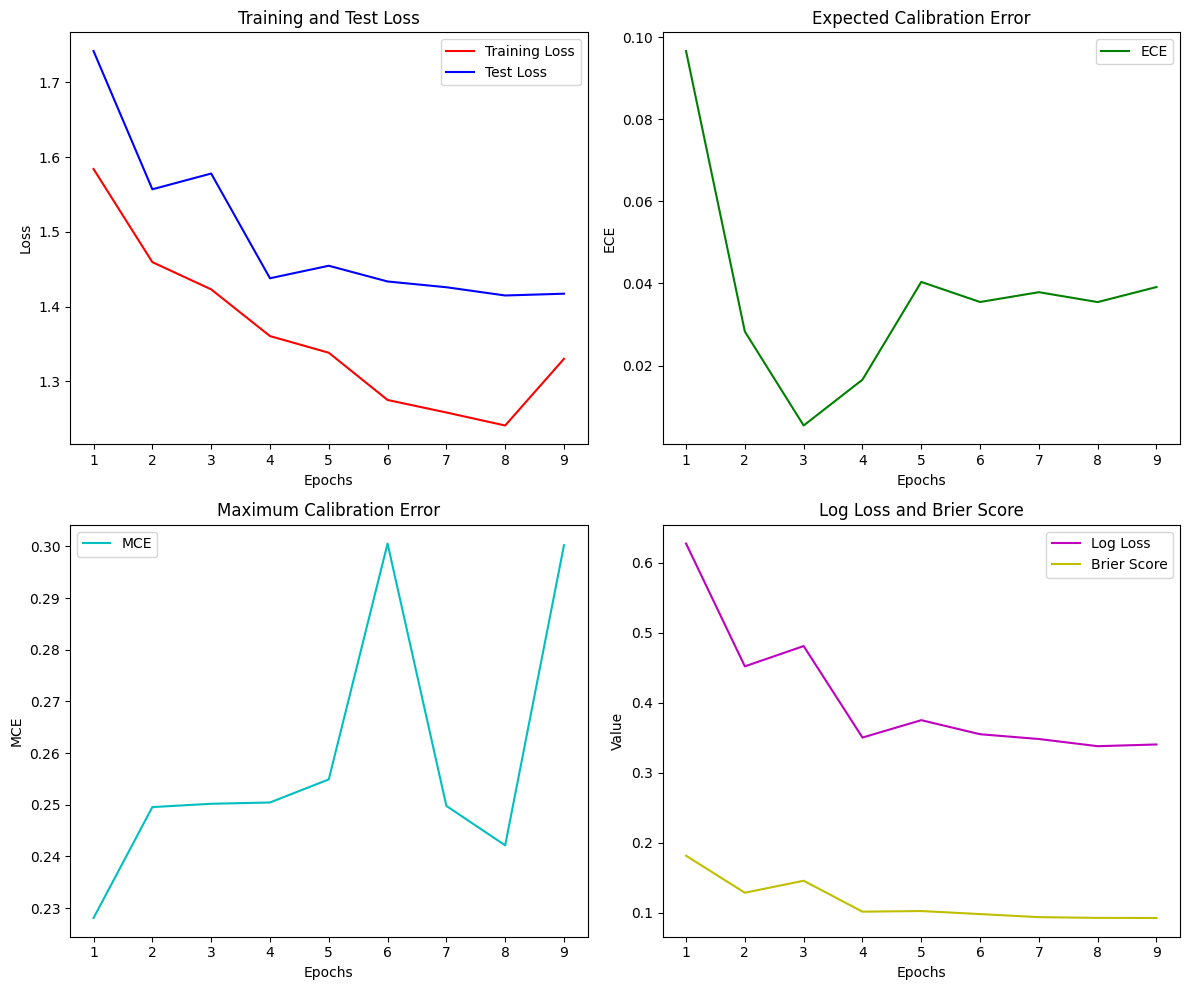

313/313 [==============================] - 9s 20ms/step
Accuracy: 88.7
Error: 11.299999999999997
ECE: 0.03808504386693238
MCE: 0.30421767830848695
Loss: 0.33999784418618173
brier: 0.09226983030921965
Current:  107
Current:  525
313/313 [==============================] - 9s 18ms/step
Accuracy: 88.06
Error: 11.939999999999998
ECE: 0.042495443972945246
MCE: 0.3070080578327179
Loss: 0.36667348958471374
brier: 0.09733838378900775
Current:  107
Current:  525
313/313 [==============================] - 9s 17ms/step
Accuracy: 88.33
Error: 11.670000000000002
ECE: 0.043700266370177196
MCE: 0.20352847046322292
Loss: 0.37242398922171827
brier: 0.09672183826922189
Current:  107
Current:  525
313/313 [==============================] - 9s 18ms/step
Accuracy: 88.68
Error: 11.319999999999993
ECE: 0.03971958154737951
MCE: 0.2600265145301819
Loss: 0.33787563521323527
brier: 0.09122583739296751
Current:  107
Current:  525
313/313 [==============================] - 10s 21ms/step
Accuracy: 88.16000000000001


(array([11.70125   ,  0.04273999,  0.22807795,  0.35740933,  0.09511829]),
 array([0.2776142 , 0.00298326, 0.05823473, 0.01337896, 0.00221541]))

In [ ]:
freezing_average(8,model, x_train45, y_train45, x_val, y_val, x_test, y_test,freezing_list_rn, batch_size=128,lr_schedule = [[0, 0.01],[25,0.001],[40,0.0001]], name='resnet_fmnist_30_0.2_45_0.98')

In [ ]:
#0.2,0.4,0.6,0.8,0.9
#10,20,30,40,45
freezing_list_rn = []
for i in range(len(model.layers)):
  if i < len(model.layers) * 0.8:
    freezing_list_rn.append(30)
  elif i < len(model.layers) * 0.9:
    freezing_list_rn.append(40)
freezing_list_rn.append(50)

Epoch 1/30
46/46 [==============================] - 30s 198ms/step - loss: 2.5374 - accuracy: 0.5476 - lr: 0.0100
Epoch 2/30
46/46 [==============================] - 9s 200ms/step - loss: 1.8817 - accuracy: 0.7159 - lr: 0.0100
Epoch 3/30
46/46 [==============================] - 9s 200ms/step - loss: 1.7328 - accuracy: 0.7793 - lr: 0.0100
Epoch 4/30
46/46 [==============================] - 9s 200ms/step - loss: 1.6677 - accuracy: 0.7970 - lr: 0.0100
Epoch 5/30
46/46 [==============================] - 9s 198ms/step - loss: 1.6201 - accuracy: 0.8110 - lr: 0.0100
Epoch 6/30
46/46 [==============================] - 38s 835ms/step - loss: 1.5966 - accuracy: 0.8273 - lr: 0.0100
Epoch 7/30
46/46 [==============================] - 9s 201ms/step - loss: 1.5811 - accuracy: 0.8345 - lr: 0.0100
Epoch 8/30
46/46 [==============================] - 9s 201ms/step - loss: 1.5566 - accuracy: 0.8386 - lr: 0.0100
Epoch 9/30
46/46 [==============================] - 9s 201ms/step - loss: 1.5165 - accuracy: 0

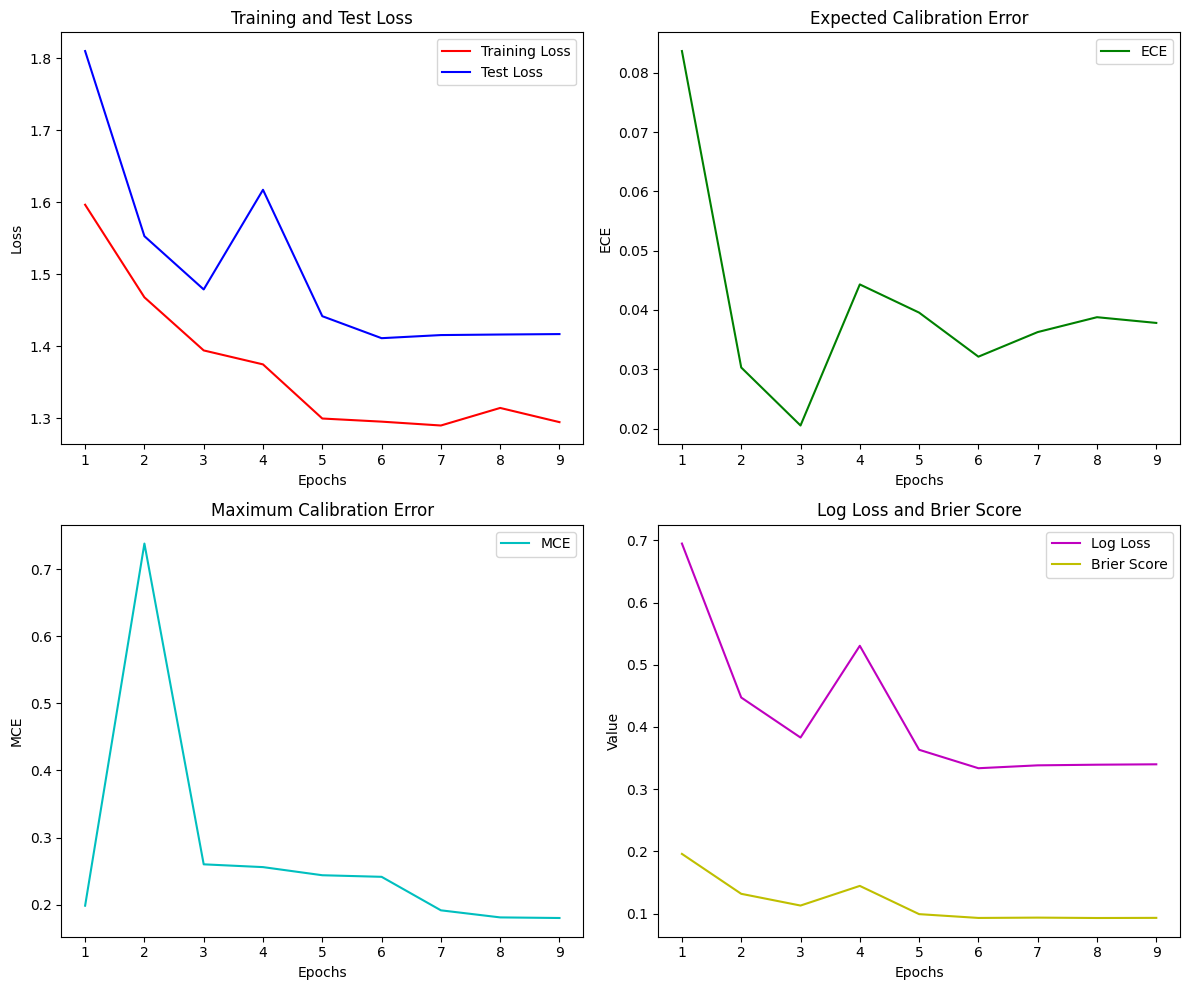

313/313 [==============================] - 10s 20ms/step
Accuracy: 88.49000000000001
Error: 11.509999999999991
ECE: 0.037884272593259855
MCE: 0.1582938447976724
Loss: 0.3400519404218445
brier: 0.0931439067634551
Current:  428
Current:  482
313/313 [==============================] - 9s 21ms/step
Accuracy: 88.12
Error: 11.879999999999995
ECE: 0.039016917745769014
MCE: 0.2346378117799759
Loss: 0.35386365144897286
brier: 0.09589736504454557
Current:  428
Current:  482
313/313 [==============================] - 9s 20ms/step
Accuracy: 88.69
Error: 11.310000000000002
ECE: 0.04148480555415157
MCE: 0.7415519058704376
Loss: 0.3557698263746418
brier: 0.09373866221680649
Current:  428
Current:  482
313/313 [==============================] - 9s 20ms/step
Accuracy: 88.21
Error: 11.790000000000006
ECE: 0.042360653799772316
MCE: 0.3146008998155594
Loss: 0.36015954191803207
brier: 0.09562075197791076
Current:  428
Current:  482
313/313 [==============================] - 10s 21ms/step
Accuracy: 87.92999

(array([11.63125   ,  0.03822571,  0.27823272,  0.34854032,  0.09436451]),
 array([0.2678719 , 0.00262714, 0.20046487, 0.00991947, 0.00186397]))

In [ ]:
freezing_average(8,model, x_train45, y_train45, x_val, y_val, x_test, y_test,freezing_list_rn, batch_size=128,lr_schedule = [[0, 0.01],[25,0.001],[40,0.0001]], name='resnet_fmnist_30_0.8_40_0.9')

In [ ]:
freezing_list_rn = []
for i in range(len(model.layers)):
  if i < len(model.layers) * 0.8:
    freezing_list_rn.append(30)
freezing_list_rn.append(50)

Epoch 1/30
46/46 [==============================] - 30s 207ms/step - loss: 2.4900 - accuracy: 0.5562 - lr: 0.0100
Epoch 2/30
46/46 [==============================] - 9s 207ms/step - loss: 1.8605 - accuracy: 0.7294 - lr: 0.0100
Epoch 3/30
46/46 [==============================] - 10s 207ms/step - loss: 1.7302 - accuracy: 0.7732 - lr: 0.0100
Epoch 4/30
46/46 [==============================] - 10s 208ms/step - loss: 1.6723 - accuracy: 0.7931 - lr: 0.0100
Epoch 5/30
46/46 [==============================] - 10s 214ms/step - loss: 1.6149 - accuracy: 0.8161 - lr: 0.0100
Epoch 6/30
46/46 [==============================] - 43s 958ms/step - loss: 1.5737 - accuracy: 0.8350 - lr: 0.0100
Epoch 7/30
46/46 [==============================] - 10s 206ms/step - loss: 1.5419 - accuracy: 0.8440 - lr: 0.0100
Epoch 8/30
46/46 [==============================] - 9s 204ms/step - loss: 1.5137 - accuracy: 0.8530 - lr: 0.0100
Epoch 9/30
46/46 [==============================] - 10s 209ms/step - loss: 1.5153 - accura

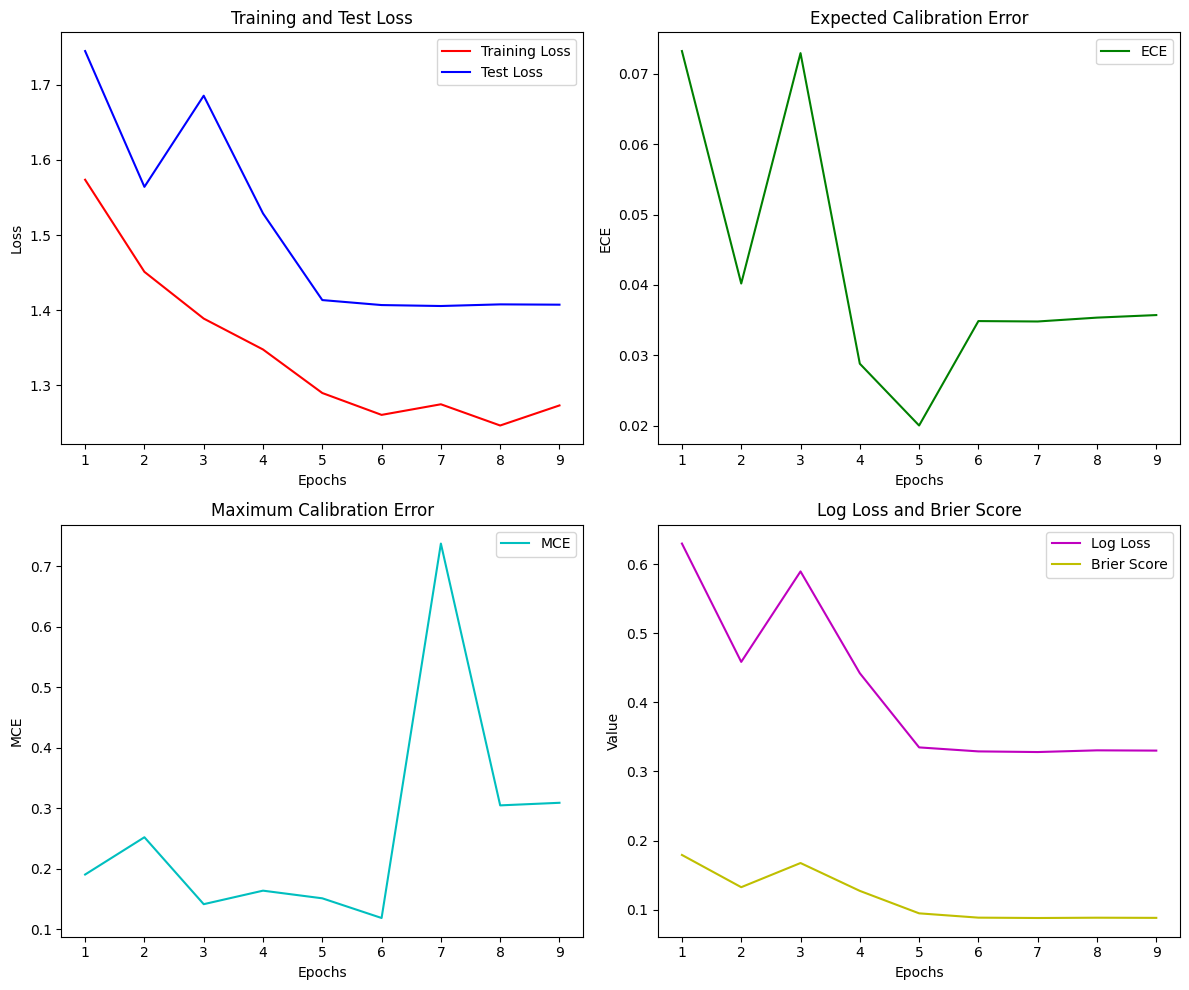

313/313 [==============================] - 10s 22ms/step
Accuracy: 89.18
Error: 10.819999999999993
ECE: 0.03618479118347169
MCE: 0.19576864441235858
Loss: 0.33049418467961844
brier: 0.08803046950823809
Current:  428
313/313 [==============================] - 9s 20ms/step
Accuracy: 88.33
Error: 11.670000000000002
ECE: 0.039998488372564305
MCE: 0.30148740112781525
Loss: 0.34017630651699676
brier: 0.09347274184267378
Current:  428
313/313 [==============================] - 9s 18ms/step
Accuracy: 88.85
Error: 11.150000000000006
ECE: 0.03621180734336375
MCE: 0.25834567844867706
Loss: 0.33817231933159103
brier: 0.09138425499066703
Current:  428
313/313 [==============================] - 10s 18ms/step
Accuracy: 88.78
Error: 11.219999999999999
ECE: 0.04084850948750972
MCE: 0.30084803104400637
Loss: 0.3445416172871855
brier: 0.09086413982336124
Current:  428
313/313 [==============================] - 9s 17ms/step
Accuracy: 88.37
Error: 11.629999999999995
ECE: 0.032452097105979905
MCE: 0.2656477

(array([11.47875   ,  0.03885764,  0.2228811 ,  0.34330169,  0.09290088]),
 array([0.41405443, 0.00452807, 0.06710694, 0.01200495, 0.00307728]))

In [ ]:
freezing_average(8,model, x_train45, y_train45, x_val, y_val, x_test, y_test,freezing_list_rn, batch_size=128,lr_schedule = [[0, 0.01],[25,0.001],[40,0.0001]], name='resnet_fmnist_30_0.8')

In [ ]:
freezing_list_rn = []
for i in range(len(model.layers)):
  if i < len(model.layers) * 0.9:
    freezing_list_rn.append(30)
freezing_list_rn.append(50)

Epoch 1/30
46/46 [==============================] - 31s 202ms/step - loss: 2.6276 - accuracy: 0.5258 - lr: 0.0100
Epoch 2/30
46/46 [==============================] - 9s 200ms/step - loss: 1.8936 - accuracy: 0.7127 - lr: 0.0100
Epoch 3/30
46/46 [==============================] - 9s 203ms/step - loss: 1.7641 - accuracy: 0.7600 - lr: 0.0100
Epoch 4/30
46/46 [==============================] - 9s 203ms/step - loss: 1.7071 - accuracy: 0.7805 - lr: 0.0100
Epoch 5/30
46/46 [==============================] - 9s 201ms/step - loss: 1.6299 - accuracy: 0.8077 - lr: 0.0100
Epoch 6/30
46/46 [==============================] - 38s 851ms/step - loss: 1.5992 - accuracy: 0.8294 - lr: 0.0100
Epoch 7/30
46/46 [==============================] - 9s 204ms/step - loss: 1.5686 - accuracy: 0.8365 - lr: 0.0100
Epoch 8/30
46/46 [==============================] - 12s 258ms/step - loss: 1.5543 - accuracy: 0.8420 - lr: 0.0100
Epoch 9/30
46/46 [==============================] - 12s 254ms/step - loss: 1.5105 - accuracy:

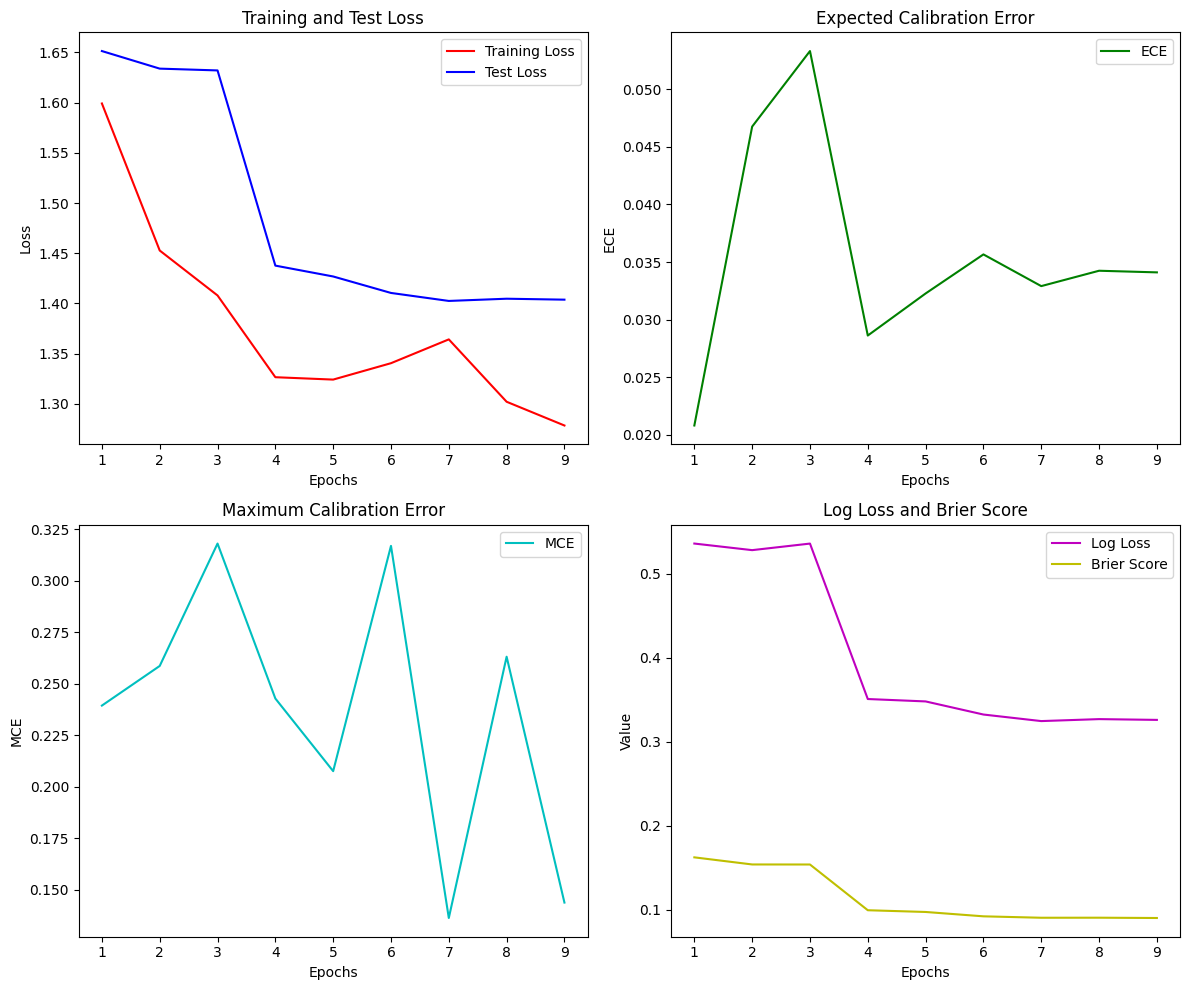

313/313 [==============================] - 9s 18ms/step
Accuracy: 88.74
Error: 11.260000000000005
ECE: 0.03359116995632648
MCE: 0.3080362230539322
Loss: 0.324787689508921
brier: 0.09011286143686811
Current:  482
313/313 [==============================] - 10s 22ms/step
Accuracy: 88.64999999999999
Error: 11.350000000000009
ECE: 0.04145005622208117
MCE: 0.3158470193545024
Loss: 0.3501827819399512
brier: 0.09337982141104716
Current:  482
313/313 [==============================] - 9s 18ms/step
Accuracy: 88.75
Error: 11.25
ECE: 0.03481761829853061
MCE: 0.25006482005119324
Loss: 0.33850581997276524
brier: 0.09150692326367436
Current:  482
313/313 [==============================] - 10s 22ms/step
Accuracy: 88.98
Error: 11.019999999999996
ECE: 0.031009098693728424
MCE: 0.11709596139229761
Loss: 0.3247426606561791
brier: 0.0899892740637132
Current:  482
313/313 [==============================] - 10s 18ms/step
Accuracy: 88.3
Error: 11.700000000000003
ECE: 0.03208849487155676
MCE: 0.259478040039539

(array([11.49375   ,  0.03508993,  0.25682548,  0.34048134,  0.09317369]),
 array([0.3311425 , 0.00555217, 0.06510181, 0.01373888, 0.00256923]))

In [ ]:
freezing_average(8,model, x_train45, y_train45, x_val, y_val, x_test, y_test,freezing_list_rn, batch_size=128,lr_schedule = [[0, 0.01],[25,0.001],[40,0.0001]], name='resnet_fmnist_30_0.9')

In [ ]:
#0.2,0.4,0.6,0.8,0.9
#10,20,30,40,45
freezing_list_rn = []
for i in range(len(model.layers)):
  if i < len(model.layers) * 0.9:
    freezing_list_rn.append(45)
freezing_list_rn.append(50)

Epoch 1/45
46/46 [==============================] - 30s 199ms/step - loss: 2.4900 - accuracy: 0.5562 - lr: 0.0100
Epoch 2/45
46/46 [==============================] - 9s 202ms/step - loss: 1.8605 - accuracy: 0.7294 - lr: 0.0100
Epoch 3/45
46/46 [==============================] - 9s 202ms/step - loss: 1.7302 - accuracy: 0.7732 - lr: 0.0100
Epoch 4/45
46/46 [==============================] - 9s 201ms/step - loss: 1.6723 - accuracy: 0.7931 - lr: 0.0100
Epoch 5/45
46/46 [==============================] - 9s 203ms/step - loss: 1.6149 - accuracy: 0.8161 - lr: 0.0100
Epoch 6/45
46/46 [==============================] - 38s 847ms/step - loss: 1.5737 - accuracy: 0.8350 - lr: 0.0100
Epoch 7/45
46/46 [==============================] - 9s 205ms/step - loss: 1.5419 - accuracy: 0.8440 - lr: 0.0100
Epoch 8/45
46/46 [==============================] - 9s 204ms/step - loss: 1.5137 - accuracy: 0.8530 - lr: 0.0100
Epoch 9/45
46/46 [==============================] - 9s 204ms/step - loss: 1.5153 - accuracy: 0

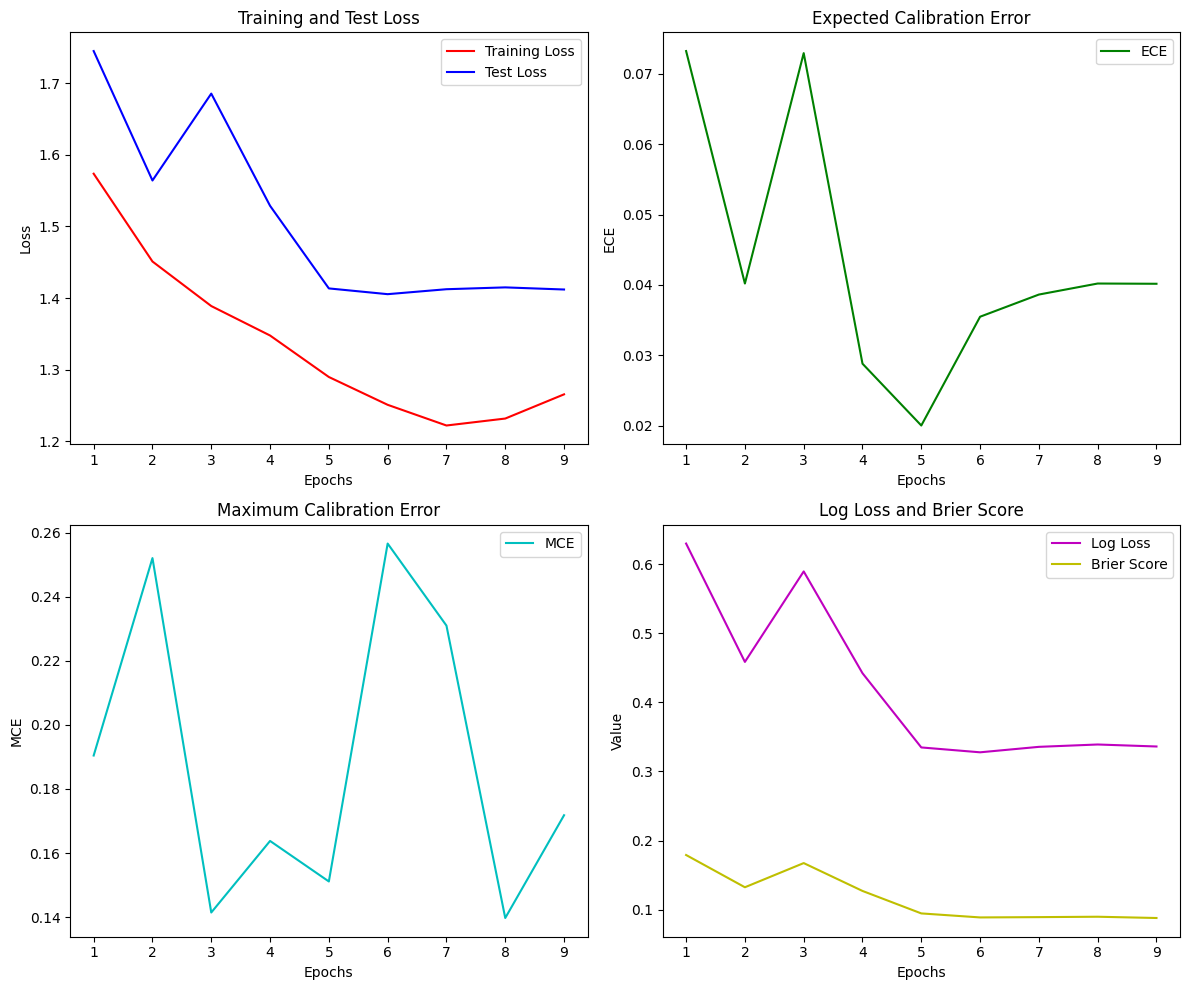

313/313 [==============================] - 8s 16ms/step
Accuracy: 89.19
Error: 10.810000000000002
ECE: 0.03977028604745872
MCE: 0.1801873624324799
Loss: 0.3369871005169249
brier: 0.08839372279490654
Current:  482
313/313 [==============================] - 9s 21ms/step
Accuracy: 88.42999999999999
Error: 11.570000000000007
ECE: 0.04439212758243077
MCE: 0.1607727325208127
Loss: 0.35010467155290287
brier: 0.09351691316974477
Current:  482
313/313 [==============================] - 11s 19ms/step
Accuracy: 88.77000000000001
Error: 11.22999999999999
ECE: 0.040843855261802675
MCE: 0.2517711818218231
Loss: 0.34624318347035854
brier: 0.09133302137137486
Current:  482
313/313 [==============================] - 9s 21ms/step
Accuracy: 88.5
Error: 11.5
ECE: 0.04631066915392875
MCE: 0.3025784194469452
Loss: 0.36309380564517785
brier: 0.09350684437117203
Current:  482
313/313 [==============================] - 8s 17ms/step
Accuracy: 88.08
Error: 11.920000000000002
ECE: 0.03781954214572907
MCE: 0.20022

(array([11.60375   ,  0.04306734,  0.22747621,  0.35391789,  0.09396192]),
 array([0.48172124, 0.00479715, 0.0599651 , 0.01424949, 0.00351886]))

In [ ]:
freezing_average(8,model, x_train45, y_train45, x_val, y_val, x_test, y_test,freezing_list_rn, batch_size=128,lr_schedule = [[0, 0.01],[25,0.001],[40,0.0001]], name='resnet_fmnist_45_0.9')

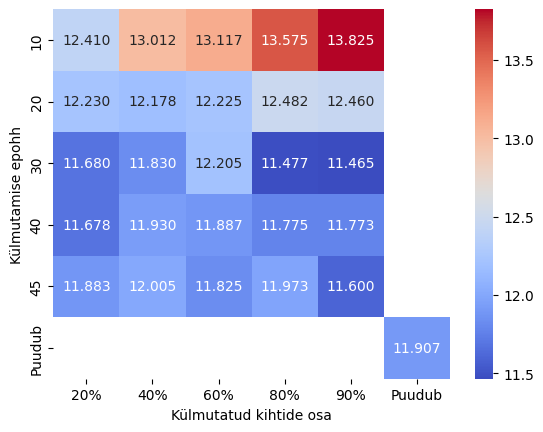

In [ ]:
#Creating some heatmaps with uncalibrated results
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Read the data from the CSV file
data = pd.read_csv('uus.csv')

# Extract the numbers after the second and third underscores in the model_name column
data['Külmutamise epohh'] = data['model_name'].str.split('_').str[2]
data['Külmutatud kihtide osa'] = data['model_name'].str.split('_').str[3]

# Pivot the DataFrame to create a matrix suitable for the heatmap
heatmap_data = data.pivot_table(index='Külmutamise epohh', columns='Külmutatud kihtide osa', values='Error_mean')

# Create the heatmap using seaborn
sns.heatmap(heatmap_data, annot=True, cmap='coolwarm',fmt='.3f')

# Display the heatmap
plt.show()

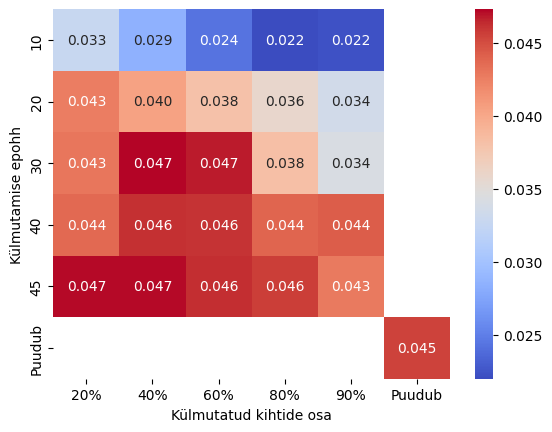

In [ ]:
heatmap_data = data.pivot_table(index='Külmutamise epohh', columns='Külmutatud kihtide osa', values='ECE_mean')

# Create the heatmap using seaborn
sns.heatmap(heatmap_data, annot=True, cmap='coolwarm',fmt='.3f')

# Display the heatmap
plt.show()

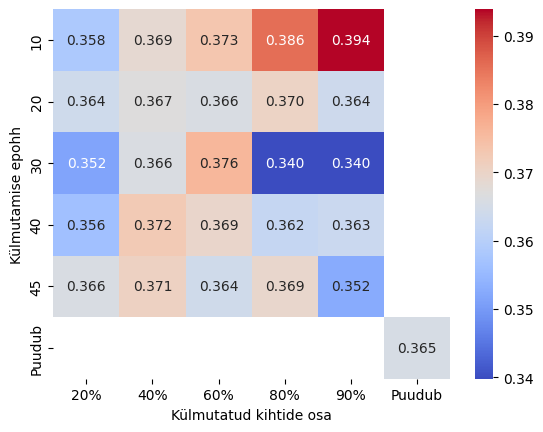

In [ ]:
heatmap_data = data.pivot_table(index='Külmutamise epohh', columns='Külmutatud kihtide osa', values='Log loss_mean')

# Create the heatmap using seaborn
sns.heatmap(heatmap_data, annot=True, cmap='coolwarm',fmt='.3f')

# Display the heatmap
plt.show()

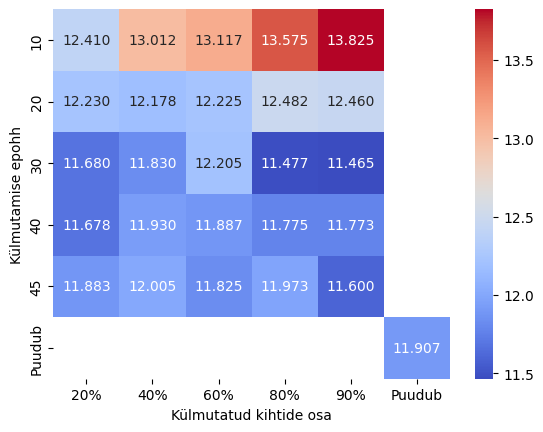

In [ ]:
#Creating some heatmaps with temperature scaling results

# Read the data from the CSV file
data = pd.read_csv('fmnist_temp_puudub.csv')

# Extract the numbers after the second and third underscores in the model_name column
data['Külmutamise epohh'] = data['model_name'].str.split('_').str[2]
data['Külmutatud kihtide osa'] = data['model_name'].str.split('_').str[3]

# Pivot the DataFrame to create a matrix suitable for the heatmap
heatmap_data = data.pivot_table(index='Külmutamise epohh', columns='Külmutatud kihtide osa', values='Error_mean')

# Create the heatmap using seaborn
sns.heatmap(heatmap_data, annot=True, cmap='coolwarm',fmt='.3f')

# Display the heatmap
plt.show()

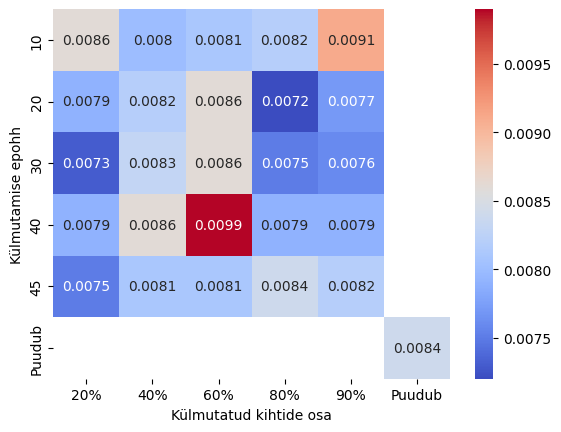

In [ ]:
heatmap_data = data.pivot_table(index='Külmutamise epohh', columns='Külmutatud kihtide osa', values='ECE_mean')

# Create the heatmap using seaborn
sns.heatmap(heatmap_data, annot=True, cmap='coolwarm')

# Display the heatmap
plt.show()

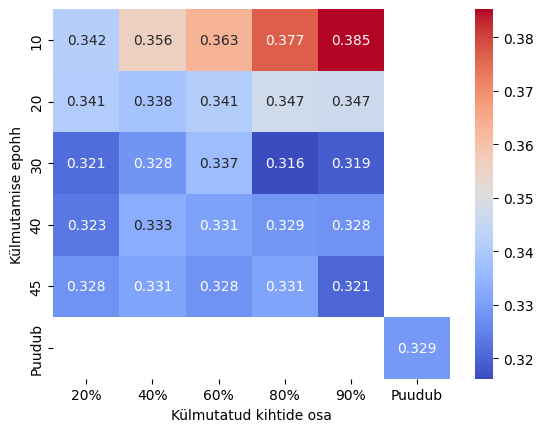

In [ ]:
heatmap_data = data.pivot_table(index='Külmutamise epohh', columns='Külmutatud kihtide osa', values='Log loss_mean')

# Create the heatmap using seaborn
sns.heatmap(heatmap_data, annot=True, cmap='coolwarm',fmt='.3f')

# Display the heatmap
plt.show()

In [ ]:
#0.2,0.4,0.6,0.8,0.9
#10,20,30,40,45
freezing_list_rn = []
for i in range(len(model.layers)):
  if i < len(model.layers) * 0.2:
    freezing_list_rn.append(40)
  elif i < len(model.layers) * 0.9:
    freezing_list_rn.append(45)
freezing_list_rn.append(50)

Epoch 1/40
46/46 [==============================] - 31s 203ms/step - loss: 2.5229 - accuracy: 0.5433 - lr: 0.0100
Epoch 2/40
46/46 [==============================] - 9s 202ms/step - loss: 1.8687 - accuracy: 0.7231 - lr: 0.0100
Epoch 3/40
46/46 [==============================] - 9s 203ms/step - loss: 1.7471 - accuracy: 0.7733 - lr: 0.0100
Epoch 4/40
46/46 [==============================] - 9s 204ms/step - loss: 1.6752 - accuracy: 0.8016 - lr: 0.0100
Epoch 5/40
46/46 [==============================] - 9s 201ms/step - loss: 1.6034 - accuracy: 0.8200 - lr: 0.0100
Epoch 6/40
46/46 [==============================] - 39s 859ms/step - loss: 1.5887 - accuracy: 0.8343 - lr: 0.0100
Epoch 7/40
46/46 [==============================] - 9s 203ms/step - loss: 1.5351 - accuracy: 0.8503 - lr: 0.0100
Epoch 8/40
46/46 [==============================] - 9s 203ms/step - loss: 1.5076 - accuracy: 0.8552 - lr: 0.0100
Epoch 9/40
46/46 [==============================] - 9s 202ms/step - loss: 1.4985 - accuracy: 0

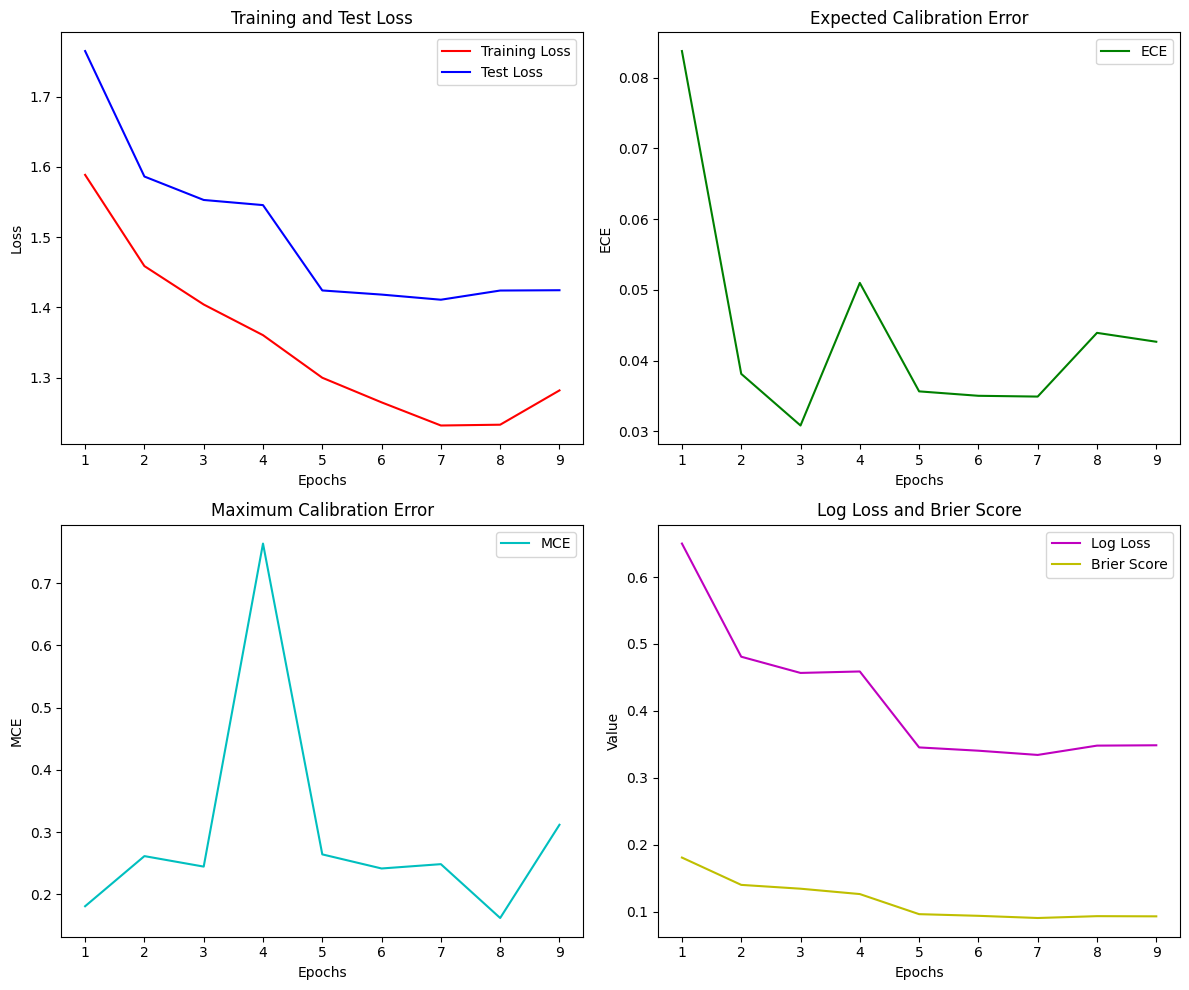

313/313 [==============================] - 10s 18ms/step
Accuracy: 88.73
Error: 11.269999999999996
ECE: 0.04176310995221132
MCE: 0.29595309495925903
Loss: 0.34392175565426564
brier: 0.09169442019599063
Current:  107
Current:  482
313/313 [==============================] - 10s 22ms/step
Accuracy: 88.13
Error: 11.870000000000005
ECE: 0.04364104544818405
MCE: 0.14725653772673952
Loss: 0.367376101974581
brier: 0.09652001928878153
Current:  107
Current:  482
313/313 [==============================] - 9s 20ms/step
Accuracy: 88.42999999999999
Error: 11.570000000000007
ECE: 0.044294578316807734
MCE: 0.7410847842693329
Loss: 0.3681309798032987
brier: 0.09545546854646227
Current:  107
Current:  482
313/313 [==============================] - 9s 20ms/step
Accuracy: 88.44
Error: 11.560000000000002
ECE: 0.04181148180067537
MCE: 0.16776332044464026
Loss: 0.34547159631621527
brier: 0.0931224733792533
Current:  107
Current:  482
313/313 [==============================] - 8s 17ms/step
Accuracy: 88.33
Er

(array([11.595     ,  0.04355307,  0.40326589,  0.35862033,  0.09424203]),
 array([0.30491217, 0.00314668, 0.30240454, 0.01286365, 0.00249445]))

In [ ]:
freezing_average(8,model, x_train45, y_train45, x_val, y_val, x_test, y_test,freezing_list_rn, batch_size=128,lr_schedule = [[0, 0.01],[25,0.001],[40,0.0001]], name='resnet_fmnist_40_0.2_45_0.9')

In [ ]:
#0.2,0.4,0.6,0.8,0.9
#10,20,30,40,45
freezing_list_rn = []
for i in range(len(model.layers)):
  if i < len(model.layers) * 0.9:
    freezing_list_rn.append(30)
  elif i < len(model.layers) * 0.98:
    freezing_list_rn.append(45)
freezing_list_rn.append(50)

Epoch 1/30
46/46 [==============================] - 31s 209ms/step - loss: 2.4992 - accuracy: 0.5448 - lr: 0.0100
Epoch 2/30
46/46 [==============================] - 10s 211ms/step - loss: 1.8731 - accuracy: 0.7294 - lr: 0.0100
Epoch 3/30
46/46 [==============================] - 10s 209ms/step - loss: 1.7047 - accuracy: 0.7832 - lr: 0.0100
Epoch 4/30
46/46 [==============================] - 10s 212ms/step - loss: 1.6739 - accuracy: 0.7973 - lr: 0.0100
Epoch 5/30
46/46 [==============================] - 10s 216ms/step - loss: 1.6053 - accuracy: 0.8261 - lr: 0.0100
Epoch 6/30
46/46 [==============================] - 39s 861ms/step - loss: 1.5711 - accuracy: 0.8401 - lr: 0.0100
Epoch 7/30
46/46 [==============================] - 10s 207ms/step - loss: 1.5612 - accuracy: 0.8391 - lr: 0.0100
Epoch 8/30
46/46 [==============================] - 10s 208ms/step - loss: 1.5469 - accuracy: 0.8432 - lr: 0.0100
Epoch 9/30
46/46 [==============================] - 10s 211ms/step - loss: 1.5041 - accu

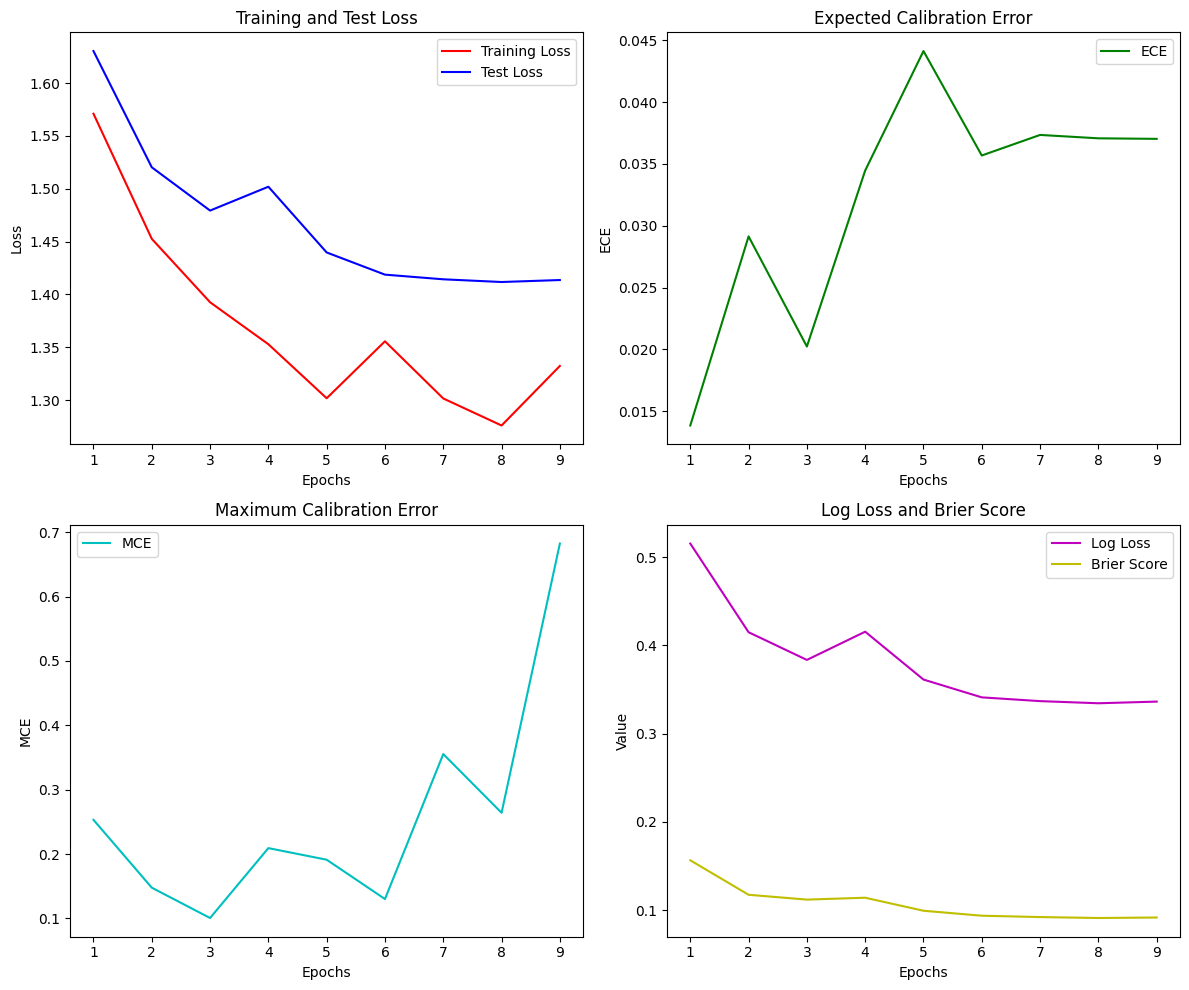

313/313 [==============================] - 10s 23ms/step
Accuracy: 88.75999999999999
Error: 11.240000000000009
ECE: 0.03689901189208031
MCE: 0.6864895820617676
Loss: 0.3370368277797318
brier: 0.09201776653833993
Current:  482
Current:  525
313/313 [==============================] - 10s 20ms/step
Accuracy: 88.17
Error: 11.829999999999998
ECE: 0.0337889494001866
MCE: 0.2544825077056885
Loss: 0.34659428174670576
brier: 0.09712797104413472
Current:  482
Current:  525
313/313 [==============================] - 8s 18ms/step
Accuracy: 88.38000000000001
Error: 11.61999999999999
ECE: 0.044613667681813254
MCE: 0.15052780283219885
Loss: 0.35444833861297886
brier: 0.09381295070164664
Current:  482
Current:  525
313/313 [==============================] - 10s 22ms/step
Accuracy: 88.24
Error: 11.760000000000005
ECE: 0.03950035797953612
MCE: 0.3234942674636841
Loss: 0.34234880899485687
brier: 0.09399967279314037
Current:  482
Current:  525
313/313 [==============================] - 10s 21ms/step
Accur

(array([11.5775    ,  0.03737207,  0.30318161,  0.34558425,  0.09411057]),
 array([0.2171734 , 0.00508176, 0.17512101, 0.00630661, 0.00190182]))

In [ ]:
freezing_average(8,model, x_train45, y_train45, x_val, y_val, x_test, y_test,freezing_list_rn, batch_size=128,lr_schedule = [[0, 0.01],[25,0.001],[40,0.0001]], name='resnet_fmnist_30_0.9_45_0.98')

In [ ]:
#0.2,0.4,0.6,0.8,0.9
#10,20,30,40,45
freezing_list_rn = []
for i in range(len(model.layers)):
  if i < len(model.layers) * 0.8:
    freezing_list_rn.append(30)
  elif i < len(model.layers) * 0.98:
    freezing_list_rn.append(45)
freezing_list_rn.append(50)

Epoch 1/30
46/46 [==============================] - 31s 214ms/step - loss: 2.4414 - accuracy: 0.5622 - lr: 0.0100
Epoch 2/30
46/46 [==============================] - 10s 207ms/step - loss: 1.8607 - accuracy: 0.7297 - lr: 0.0100
Epoch 3/30
46/46 [==============================] - 9s 201ms/step - loss: 1.7129 - accuracy: 0.7815 - lr: 0.0100
Epoch 4/30
46/46 [==============================] - 9s 203ms/step - loss: 1.6644 - accuracy: 0.8048 - lr: 0.0100
Epoch 5/30
46/46 [==============================] - 9s 203ms/step - loss: 1.6148 - accuracy: 0.8162 - lr: 0.0100
Epoch 6/30
46/46 [==============================] - 35s 765ms/step - loss: 1.5841 - accuracy: 0.8350 - lr: 0.0100
Epoch 7/30
46/46 [==============================] - 9s 205ms/step - loss: 1.5407 - accuracy: 0.8489 - lr: 0.0100
Epoch 8/30
46/46 [==============================] - 9s 204ms/step - loss: 1.5181 - accuracy: 0.8498 - lr: 0.0100
Epoch 9/30
46/46 [==============================] - 9s 203ms/step - loss: 1.4953 - accuracy: 

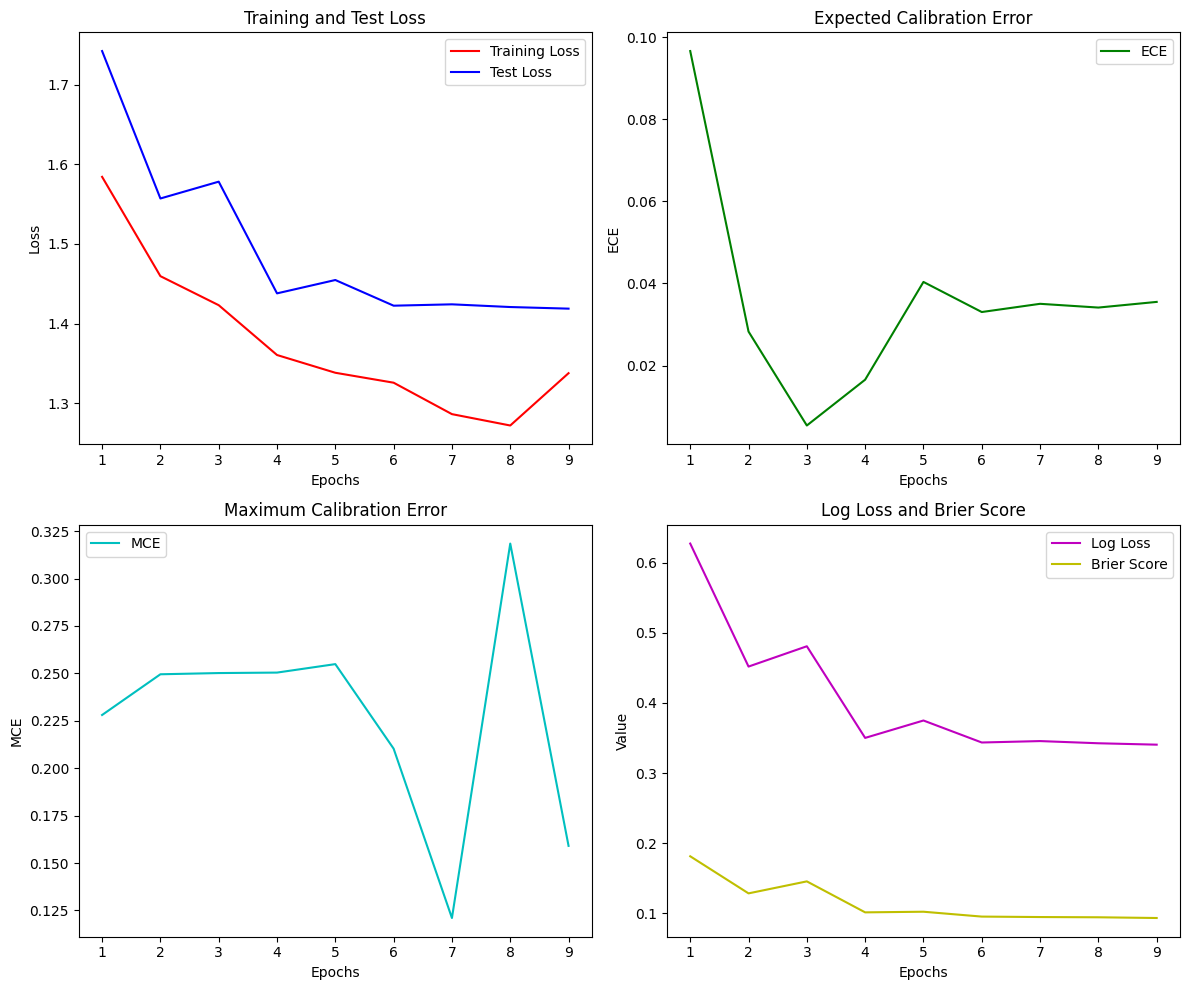

313/313 [==============================] - 9s 17ms/step
Accuracy: 88.5
Error: 11.5
ECE: 0.034705514627695055
MCE: 0.142050230170626
Loss: 0.33958098815680926
brier: 0.09305597828095029
Current:  428
Current:  525
313/313 [==============================] - 9s 18ms/step
Accuracy: 88.29
Error: 11.709999999999994
ECE: 0.039793722081184375
MCE: 0.77311110496521
Loss: 0.35883437426191733
brier: 0.09639492720035234
Current:  428
Current:  525
313/313 [==============================] - 9s 17ms/step
Accuracy: 88.35
Error: 11.650000000000006
ECE: 0.03971110064387316
MCE: 0.23358712548559363
Loss: 0.3605136849421513
brier: 0.09587517896592021
Current:  428
Current:  525
313/313 [==============================] - 10s 21ms/step
Accuracy: 88.66000000000001
Error: 11.33999999999999
ECE: 0.03576091832965609
MCE: 0.7610091418027878
Loss: 0.32991324698175495
brier: 0.0910669737794661
Current:  428
Current:  525
313/313 [==============================] - 9s 18ms/step
Accuracy: 87.99
Error: 12.01000000000

(array([11.6325    ,  0.03918753,  0.33173266,  0.34988742,  0.0945435 ]),
 array([0.22926902, 0.00276857, 0.27166651, 0.01046229, 0.00197456]))

In [ ]:
freezing_average(8,model, x_train45, y_train45, x_val, y_val, x_test, y_test,freezing_list_rn, batch_size=128,lr_schedule = [[0, 0.01],[25,0.001],[40,0.0001]], name='resnet_fmnist_30_0.8_45_0.98')

In [ ]:
#Everything at the bottom of this file is about applying temperature scaling to FMNIST weights
# Weights files are not included in the repository

In [ ]:
from scipy.optimize import minimize
class TemperatureScaling():

    def __init__(self, temp=1, maxiter=50, solver="BFGS"):
        """
        Initialize class
        
        Params:
            temp (float): starting temperature, default 1
            maxiter (int): maximum iterations done by optimizer, however 8 iterations have been maximum.
        """
        self.temp = temp
        self.maxiter = maxiter
        self.solver = solver

    def _loss_fun(self, x, probs, true):
        # Calculates the loss using log-loss (cross-entropy loss)
        scaled_probs = self.predict(probs, x)
        loss = log_loss(y_true=true, y_pred=scaled_probs)
        return loss

    # Find the temperature
    def fit(self, logits, true):
        """
        Trains the model and finds optimal temperature
        
        Params:
            logits: the output from neural network for each class (shape [samples, classes])
            true: one-hot-encoding of true labels.
            
        Returns:
            the results of optimizer after minimizing is finished.
        """

        true = true.flatten()  # Flatten y_val
        opt = minimize(self._loss_fun, x0=1, args=(logits, true), options={'maxiter': self.maxiter}, method=self.solver)
        self.temp = opt.x[0]

        return opt

    def predict(self, logits, temp=None):
        """
        Scales logits based on the temperature and returns calibrated probabilities
        
        Params:
            logits: logits values of data (output from neural network) for each class (shape [samples, classes])
            temp: if not set use temperatures find by model or previously set.
            
        Returns:
            calibrated probabilities (nd.array with shape [samples, classes])
        """

        if not temp:
            logits_tensor = tf.convert_to_tensor(logits/self.temp)  # Convert NumPy array to TensorFlow tensor
            return keras_softmax(logits_tensor, axis=-1)
        else:
            logits_tensor = tf.convert_to_tensor(logits/temp)
            return keras_softmax(logits_tensor, axis=-1)

In [ ]:
def evaluate2(probs, y_true, verbose=False, normalize=False, bins=15):
    """
    Evaluate model using various scoring measures: Error Rate, ECE, MCE, NLL, Brier Score
    
    Params:
        probs: a list containing probabilities for all the classes with a shape of (samples, classes)
        y_true: a list containing the actual class labels
        verbose: (bool) are the scores printed out. (default = False)
        normalize: (bool) in case of 1-vs-K calibration, the probabilities need to be normalized.
        bins: (int) - into how many bins are probabilities divided (default = 15)
        
    Returns:
        (error, ece, mce, loss, brier), returns various scoring measures
    """
    probs = probs.numpy()
    preds = np.argmax(probs, axis=1)  # Take maximum confidence as prediction

    if normalize:
        confs = np.max(probs, axis=1) / np.sum(probs, axis=1)
        # Check if everything below or equal to 1?
    else:
        confs = np.max(probs, axis=1)  # Take only maximum confidence

    if len(y_true.shape) > 1 and y_true.shape[1] > 1:  # If 1-hot representation, get back to numeric
      y_true = np.array([[np.where(r == 1)[0][0]] for r in y_true])  # Back to np array also

    accuracy = metrics.accuracy_score(y_true, preds) * 100
    error = 100 - accuracy

    # Calculate ECE
    ece = ECE(confs, preds, y_true, bin_size=1 / bins)
    # Calculate MCE
    mce = MCE(confs, preds, y_true, bin_size=1 / bins)
    loss = log_loss(y_true=y_true, y_pred=probs)
    # Calculate Brier score for each class
    y_prob_true = np.array([probs[i, idx] for i, idx in enumerate(y_true)])
    for i in range(len(y_true)):
      y_true[i] = 1
    brier = brier_score_loss(y_true=y_true, y_prob=y_prob_true)  # Brier Score (MSE)

    return (error, ece, mce, loss, brier)

In [ ]:
def cal_results(fn,name, logits_val,logits_test,y_val,y_test, m_kwargs={}, approach="all"):
    """
    Calibrate models scores, using output from logits files and given function (fn). 
    There are implemented to different approaches "all" and "1-vs-K" for calibration,
    the approach of calibration should match with function used for calibration.
    
    TODO: split calibration of single and all into separate functions for more use cases.
    
    Params:
        fn (class): class of the calibration method used. It must contain methods "fit" and "predict", 
                    where first fits the models and second outputs calibrated probabilities.
        path (string): path to the folder with logits files
        files (list of strings): pickled logits files ((logits_val, y_val), (logits_test, y_test))
        m_kwargs (dictionary): keyword arguments for the calibration class initialization
        approach (string): "all" for multiclass calibration and "1-vs-K" for 1-vs-K approach.
        
    Returns:
        df (pandas.DataFrame): dataframe with calibrated and uncalibrated results for all the input files.
    
    """

    df = pd.DataFrame(columns=["Name", "Error", "ECE", "MCE", "Loss", "Brier"])

    total_t1 = time.time()

    if approach == "all":
        if y_val.shape[1] > 1:  # If 1-hot representation, get back to numeric
          y_val = np.array([[np.where(r == 1)[0][0]] for r in y_val])  # Back to np array also

        y_val = y_val.flatten()

        model = fn(**m_kwargs)

        model.fit(logits_val, y_val)

        probs_val = model.predict(logits_val)
        probs_test = model.predict(logits_test)
        logits_tensor = tf.convert_to_tensor(logits_test)  # Convert NumPy array to TensorFlow tensor
        error, ece, mce, loss, brier = evaluate2(keras_softmax(logits_tensor, axis=-1), y_test, verbose=True)  # Test before scaling
        error2, ece2, mce2, loss2, brier2 = evaluate2(probs_test, y_test, verbose=False)

        print("Error %f; ece %f; mce %f; loss %f, brier %f" % evaluate2(probs_val, y_val, verbose=False,
                                                                        normalize=True))


    else:  # 1-vs-k models
        probs_val = keras_softmax(logits_val)  # Softmax logits
        probs_test = keras_softmax(logits_test)
        K = probs_test.shape[1]

        # Go through all the classes
        for k in range(K):
            # Prep class labels (1 fixed true class, 0 other classes)
            y_cal = np.array(y_val == k, dtype="int")[:, 0]

            # Train model
            model = fn(**m_kwargs)
            model.fit(probs_val[:, k], y_cal)  # Get only one column with probs for given class "k"

            probs_val[:, k] = model.predict(probs_val[:, k])  # Predict new values based on the fittting
            probs_test[:, k] = model.predict(probs_test[:, k])

            # Replace NaN with 0, as it should be close to zero  # TODO is it needed?
            idx_nan = np.where(np.isnan(probs_test))
            probs_test[idx_nan] = 0

            idx_nan = np.where(np.isnan(probs_val))
            probs_val[idx_nan] = 0

        # Get results for test set
        error, ece, mce, loss, brier = evaluate2(keras_softmax(logits_test), y_test, verbose=True, normalize=False)
        error2, ece2, mce2, loss2, brier2 = evaluate2(probs_test, y_test, verbose=False, normalize=True)

        print("Error %f; ece %f; mce %f; loss %f, brier %f" % evaluate2(probs_val, y_val, verbose=False,
                                                                        normalize=True))

    return error2, ece2, mce2, loss2, brier2

In [ ]:
def temp_scaling(model,weights_file,name,x_val,x_test,y_val,y_test):
  last_layer = model.layers.pop()
  last_layer.activation = keras.activations.linear
  i = model.input
  o = last_layer(model.layers[-2].output)

  model = keras.models.Model(inputs=i, outputs=[o])

  # First load in the weights
  model.load_weights(weights_file)
  model.compile(optimizer="sgd", loss="categorical_crossentropy")
  # Next get predictions
  logits_val = model.predict(x_val, verbose=1)
  logits_test = model.predict(x_test, verbose=1)
  error, ece, mce, loss, brier = cal_results(TemperatureScaling,name,logits_val,logits_test,y_val,y_test, approach = "all")
  write_metrics_to_csv(name + '.csv', error, ece, mce, loss, brier)
  
  return error, ece, mce, loss, brier

In [ ]:
def temp_for_each(model,name,files,x_val,x_test,y_val,y_test):
  print(name)
  model_copy = copy.deepcopy(model)
  results = np.zeros((len(files), 5))
  for i, weights_file in enumerate(files):
    test_results = temp_scaling(model_copy,weights_file,name,x_val,x_test,y_val,y_test)
    results[i, :] = test_results

  mean = np.mean(results, axis=0)
  std_dev = np.std(results, axis=0, ddof=1)

  value_names = ["Error", "ECE", "MCE", "Log loss", "Brier score"]
  print(name + ", " + str(len(files)))
  for i, (mean_value, std_dev_value) in enumerate(zip(mean, std_dev)):
      print(f"{value_names[i]}: Mean = {mean_value}, Standard Deviation = {std_dev_value}")
  sorted_results = np.sort(results, axis=0)
  reduced_results = sorted_results[2:-2]  # Remove the 2 best and 2 worst results

  mean_reduced = np.mean(reduced_results, axis=0)
  std_dev_reduced = np.std(reduced_results, axis=0, ddof=1)

  value_names = ["Error", "ECE", "MCE", "Log loss", "Brier score"]
  print(name + ", " + str(len(files)))
  for i, (mean_value, std_dev_value) in enumerate(zip(mean_reduced, std_dev_reduced)):
      print(f"{value_names[i]}: Mean Reduced = {mean_value}, Standard Deviation = {std_dev_value}")
  write_mean_and_std_to_csv('mean_and_std_values_full_fmnist.csv', name, value_names, mean, std_dev)

  # Call the function for reduced results
  write_mean_and_std_to_csv('fmnist_results_reduced.csv', name, value_names, mean_reduced, std_dev_reduced)

In [ ]:
import re
def temp_for_each_model(model,models,all_files,x_val,x_test,y_val,y_test):
  groups = {value: [] for value in models}

  for s in all_files:
      match = re.match(r'(resnet_fmnist_[\d_\.]+)(?: \(\d+\))?', s)
      if match:
          key = match.group(1)
          if key in groups:
              groups[key].append(s)
  for name, model_files in groups.items():
    if len(model_files) == 7:
      model_files.append(name+'.h5')
      temp_for_each(model,name,model_files,x_val,x_test,y_val,y_test)
    else:
      print(name)
      print(model_files)

In [ ]:
import os

# Use os.listdir to get the list of files and folders in the directory
files = os.listdir('all_h5_files4')
models = set()
# Iterate through the list and print only the files
for item in files:
  if '(' not in item and '.h5' in item:
    models.add(item[:-3])
models

{'resnet_fmnist_30_0.2_40_0.6',
 'resnet_fmnist_30_0.2_45_0.4',
 'resnet_fmnist_30_0.2_48_0.98',
 'resnet_fmnist_30_0.8_45_0.9',
 'resnet_fmnist_30_0.8_45_0.95',
 'resnet_fmnist_30_0.8_48_0.98',
 'resnet_fmnist_30_0.9_48_0.98',
 'resnet_fmnist_40_0.2_45_0.6',
 'resnet_fmnist_40_0.2_45_0.8',
 'resnet_fmnist_40_0.2_45_0.95',
 'resnet_fmnist_40_0.2_48_0.98'}

In [ ]:
model_copy = copy.deepcopy(model)

In [ ]:
x_val2,_ , y_val2,_ = train_test_split(x_val, y_val, test_size=0.9,
                                                      random_state=seed) 

In [ ]:
files  = []
for i in range(8):
  for j in models:
    files.append(j+'_'+str(i)+'.h5')
files

['resnet_fmnist_30_0.2_45_0.95_0.h5',
 'resnet_fmnist_30_0.2_45_0.95_1.h5',
 'resnet_fmnist_30_0.2_45_0.95_2.h5',
 'resnet_fmnist_30_0.2_45_0.95_3.h5',
 'resnet_fmnist_30_0.2_45_0.95_4.h5',
 'resnet_fmnist_30_0.2_45_0.95_5.h5',
 'resnet_fmnist_30_0.2_45_0.95_6.h5',
 'resnet_fmnist_30_0.2_45_0.95_7.h5']

In [ ]:
for mode in models:
  temp_for_each(model_copy,mode,files,x_val2,x_test,y_val2,y_test)

resnet_fmnist_30_0.2_45_0.95
313/313 [==============================] - 5s 17ms/step
Error 11.407407; ece 0.011569; mce 0.168080; loss 0.314300, brier 0.093999
313/313 [==============================] - 7s 21ms/step
Error 11.962963; ece 0.012343; mce 0.259894; loss 0.326900, brier 0.098056
313/313 [==============================] - 5s 16ms/step
Error 11.259259; ece 0.009714; mce 0.250738; loss 0.313659, brier 0.093746
313/313 [==============================] - 5s 16ms/step
Error 11.648148; ece 0.006247; mce 0.241435; loss 0.319994, brier 0.096256
313/313 [==============================] - 7s 21ms/step
Error 11.518519; ece 0.011067; mce 0.259723; loss 0.312481, brier 0.094522
313/313 [==============================] - 5s 16ms/step
Error 11.648148; ece 0.007962; mce 0.155060; loss 0.317451, brier 0.095391
313/313 [==============================] - 6s 19ms/step
Error 11.944444; ece 0.009763; mce 0.253534; loss 0.321760, brier 0.097106
313/313 [==============================] - 6s 18ms/ste

In [ ]:
for mode in models:
  temp_for_each(model_copy,mode,files,x_val2,x_test,y_val2,y_test)

resnet_fmnist_40_0.2_45_0.98
313/313 [==============================] - 7s 21ms/step
Error 11.851852; ece 0.013673; mce 0.137182; loss 0.320483, brier 0.096844
313/313 [==============================] - 6s 18ms/step
Error 11.629630; ece 0.014562; mce 0.417714; loss 0.319683, brier 0.096043
313/313 [==============================] - 6s 20ms/step
Error 11.814815; ece 0.010192; mce 0.768463; loss 0.325678, brier 0.098175
313/313 [==============================] - 5s 17ms/step
Error 11.851852; ece 0.012842; mce 0.234927; loss 0.319139, brier 0.096927
313/313 [==============================] - 7s 22ms/step
Error 12.407407; ece 0.013397; mce 0.774940; loss 0.324399, brier 0.098730
313/313 [==============================] - 6s 19ms/step
Error 11.777778; ece 0.010801; mce 0.362691; loss 0.321706, brier 0.098143
313/313 [==============================] - 6s 18ms/step
Error 11.444444; ece 0.012991; mce 0.143122; loss 0.311877, brier 0.093567
313/313 [==============================] - 9s 28ms/ste

In [ ]:
temp_for_each_model(model_copy,models,files,x_val2,x_test,y_val2,y_test)

resnet_fmnist_40_0.2_48_0.98
313/313 [==============================] - 6s 18ms/step
Error 12.240741; ece 0.012568; mce 0.079929; loss 0.323633, brier 0.099062
313/313 [==============================] - 5s 17ms/step
Error 11.944444; ece 0.009097; mce 0.252924; loss 0.328089, brier 0.098136
313/313 [==============================] - 8s 24ms/step
Error 12.148148; ece 0.010597; mce 0.239300; loss 0.326308, brier 0.098346
313/313 [==============================] - 5s 17ms/step
Error 11.388889; ece 0.009131; mce 0.198583; loss 0.307182, brier 0.091911
313/313 [==============================] - 7s 21ms/step
Error 11.962963; ece 0.011903; mce 0.156102; loss 0.325585, brier 0.097910
313/313 [==============================] - 6s 18ms/step
Error 11.666667; ece 0.013637; mce 0.174163; loss 0.321927, brier 0.096747
313/313 [==============================] - 5s 17ms/step
Error 11.833333; ece 0.012929; mce 0.251509; loss 0.318578, brier 0.096298
313/313 [==============================] - 5s 17ms/ste

In [ ]:
temp_for_each_model(model_copy,models,files,x_val2,x_test,y_val2,y_test)

resnet_fmnist_30_0.2_45_0.6
313/313 [==============================] - 6s 18ms/step
Error 11.851852; ece 0.008513; mce 0.243812; loss 0.322574, brier 0.096894
313/313 [==============================] - 5s 16ms/step
Error 11.666667; ece 0.011887; mce 0.250952; loss 0.319991, brier 0.096008
313/313 [==============================] - 5s 16ms/step
Error 12.574074; ece 0.015281; mce 0.207152; loss 0.341255, brier 0.103110
313/313 [==============================] - 5s 17ms/step
Error 11.370370; ece 0.012071; mce 0.154965; loss 0.315349, brier 0.094611
313/313 [==============================] - 5s 16ms/step
Error 11.388889; ece 0.011348; mce 0.235427; loss 0.310496, brier 0.093281
313/313 [==============================] - 6s 20ms/step
Error 11.111111; ece 0.014320; mce 0.090601; loss 0.307514, brier 0.092618
313/313 [==============================] - 5s 16ms/step
Error 11.777778; ece 0.012184; mce 0.170558; loss 0.325688, brier 0.096587
313/313 [==============================] - 6s 18ms/step

In [ ]:
temp_for_each_model(model_copy,models,files,x_val2,x_test,y_val2,y_test)

resnet_fmnist_30_0.8_45_0.9
313/313 [==============================] - 7s 21ms/step
Error 12.407407; ece 0.012134; mce 0.263031; loss 0.330946, brier 0.100228
313/313 [==============================] - 7s 22ms/step
Error 12.037037; ece 0.013419; mce 0.085215; loss 0.324557, brier 0.097391
313/313 [==============================] - 6s 18ms/step
Error 10.851852; ece 0.010555; mce 0.261595; loss 0.313251, brier 0.093222
313/313 [==============================] - 6s 17ms/step
Error 11.833333; ece 0.009598; mce 0.146104; loss 0.320876, brier 0.096676
313/313 [==============================] - 7s 22ms/step
Error 11.333333; ece 0.012191; mce 0.254225; loss 0.315841, brier 0.094253
313/313 [==============================] - 10s 32ms/step
Error 11.277778; ece 0.009878; mce 0.256039; loss 0.311088, brier 0.093344
313/313 [==============================] - 6s 18ms/step
Error 12.018519; ece 0.010806; mce 0.246903; loss 0.324640, brier 0.097167
313/313 [==============================] - 5s 17ms/ste

In [ ]:
temp_for_each_model(model_copy,models,files,x_val2,x_test,y_val2,y_test)

resnet_fmnist_10_0.2
313/313 [==============================] - 6s 18ms/step
Error 68.759259; ece 0.208928; mce 0.426766; loss 1.550095, brier 0.559558
313/313 [==============================] - 6s 19ms/step
Error 14.074074; ece 0.009380; mce 0.751348; loss 0.403612, brier 0.121948
313/313 [==============================] - 6s 20ms/step
Error 18.500000; ece 0.016360; mce 0.250328; loss 0.489234, brier 0.155211
313/313 [==============================] - 6s 19ms/step
Error 15.537037; ece 0.007628; mce 0.090496; loss 0.433325, brier 0.132664
313/313 [==============================] - 6s 20ms/step
Error 17.833333; ece 0.014623; mce 0.241440; loss 0.492344, brier 0.154645
313/313 [==============================] - 5s 17ms/step
Error 78.055556; ece 0.170043; mce 0.208227; loss 2.286161, brier 0.804286
313/313 [==============================] - 6s 20ms/step
Error 14.666667; ece 0.013225; mce 0.255736; loss 0.423983, brier 0.126161
313/313 [==============================] - 6s 19ms/step
Error 

In [ ]:
temp_for_each_model(model_copy,models,files,x_val2,x_test,y_val2,y_test)

resnet_fmnist_20_0.4
313/313 [==============================] - 7s 21ms/step
Error 11.944444; ece 0.010376; mce 0.176144; loss 0.333612, brier 0.099471
313/313 [==============================] - 5s 17ms/step
Error 12.037037; ece 0.009566; mce 0.262662; loss 0.327234, brier 0.098859
313/313 [==============================] - 5s 16ms/step
Error 12.611111; ece 0.013473; mce 0.120822; loss 0.344406, brier 0.104063
313/313 [==============================] - 7s 21ms/step
Error 11.777778; ece 0.009388; mce 0.253554; loss 0.325305, brier 0.097456
313/313 [==============================] - 6s 19ms/step
Error 11.703704; ece 0.007546; mce 0.258271; loss 0.326561, brier 0.097325
313/313 [==============================] - 5s 17ms/step
Error 11.777778; ece 0.008051; mce 0.098329; loss 0.327315, brier 0.099273
313/313 [==============================] - 6s 20ms/step
Error 12.481481; ece 0.012299; mce 0.134885; loss 0.332320, brier 0.100920
313/313 [==============================] - 5s 17ms/step
Error 

In [ ]:
normal = []
for i in files:
  if 'resnet_fmnist_10_0.2 ' in i and '.csv' not in i:
    normal.append(i)
normal.append('resnet_fmnist_10_0.2.h5')
normal

In [ ]:
temp_for_each(model_copy,'resnet_fmnist_10_0.2',normal,x_val2,x_test,y_val2,y_test)

resnet_fmnist_10_0.2
313/313 [==============================] - 7s 21ms/step
Error 12.537037; ece 0.007748; mce 0.256432; loss 0.343731, brier 0.103082
313/313 [==============================] - 5s 17ms/step
Error 11.851852; ece 0.010285; mce 0.242811; loss 0.330029, brier 0.099069
313/313 [==============================] - 6s 19ms/step
Error 12.296296; ece 0.010660; mce 0.294496; loss 0.337029, brier 0.101196
313/313 [==============================] - 5s 16ms/step
Error 13.333333; ece 0.012981; mce 0.250211; loss 0.355244, brier 0.107844
313/313 [==============================] - 6s 18ms/step
Error 12.703704; ece 0.010801; mce 0.246696; loss 0.332396, brier 0.101377
313/313 [==============================] - 6s 20ms/step
Error 12.425926; ece 0.013286; mce 0.076837; loss 0.339992, brier 0.102702
313/313 [==============================] - 5s 16ms/step
Error 12.148148; ece 0.014693; mce 0.240688; loss 0.336099, brier 0.101229
313/313 [==============================] - 5s 16ms/step
Error 

In [ ]:
import pandas as pd

def extract_name_parts(model_name):
    parts = model_name.split('_')
    main_part = f"{parts[2]};{parts[3]}"
    
    if len(parts) > 4:
        extra_part = f"{parts[4]};{parts[5]}"
    else:
        extra_part = 'Puudub'
        
    return main_part, extra_part

# Read the data from the CSV file
# Replace 'data.csv' with the actual path to your CSV file
data = pd.read_csv('fmnist_results.csv')

# Apply the extract_name_parts function to the model_name column
data[['Esimene külmutamine', 'Teine külmutamine']] = data['model_name'].apply(extract_name_parts).apply(pd.Series)

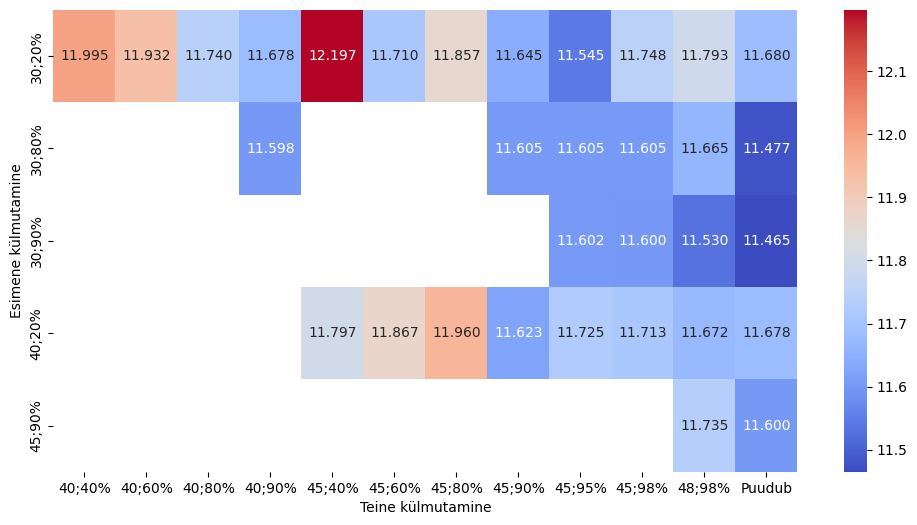

In [ ]:

import seaborn as sns
import matplotlib.pyplot as plt

# Pivot the DataFrame to create a matrix suitable for the heatmap
heatmap_data = data.pivot_table(index='Esimene külmutamine', columns='Teine külmutamine', values='Error_mean')

plt.figure(figsize=(12, 6))
# Create the heatmap using seaborn with 2 decimal places in annotations
sns.heatmap(heatmap_data, annot=True, cmap='coolwarm', fmt='.3f')

# Display the heatmap
plt.show()

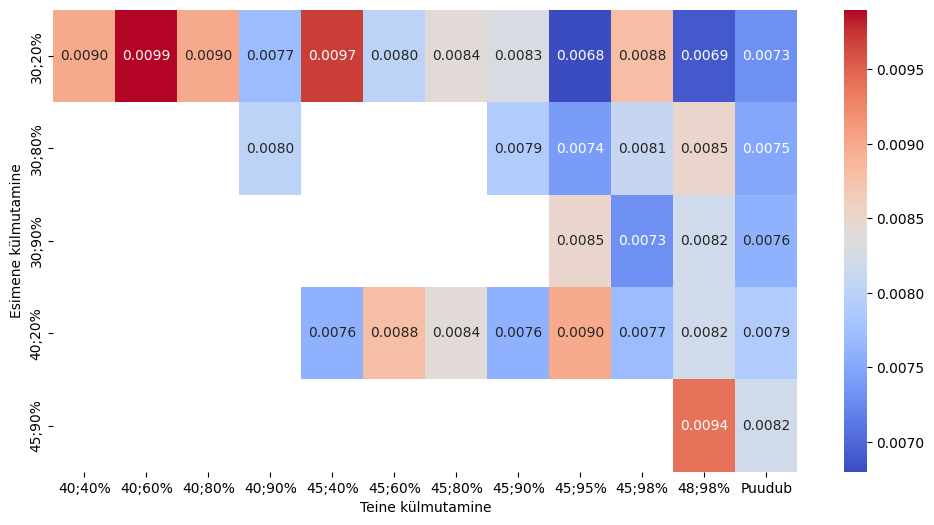

In [ ]:

import seaborn as sns
import matplotlib.pyplot as plt

# Pivot the DataFrame to create a matrix suitable for the heatmap
heatmap_data = data.pivot_table(index='Esimene külmutamine', columns='Teine külmutamine',values='ECE_mean')

plt.figure(figsize=(12, 6))
# Create the heatmap using seaborn with 2 decimal places in annotations
sns.heatmap(heatmap_data, annot=True, cmap='coolwarm', fmt='.4f')

# Display the heatmap
plt.show()

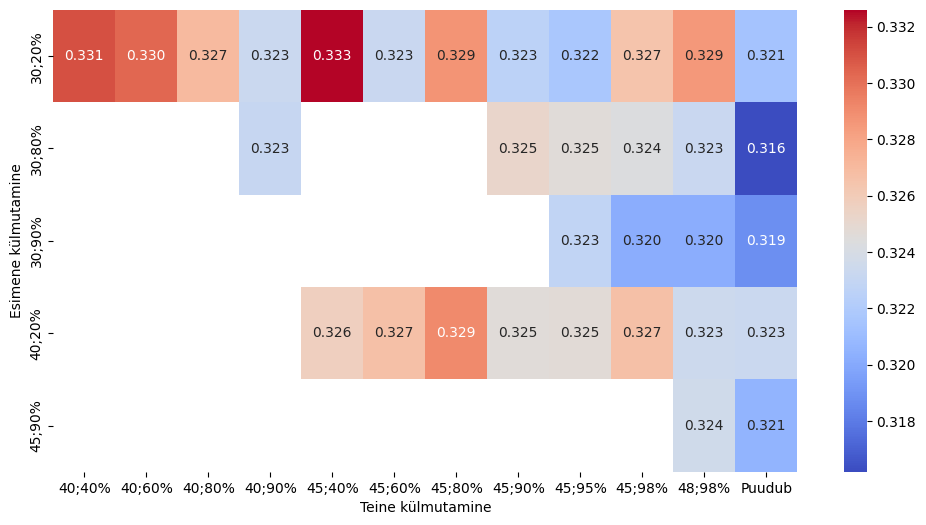

In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Pivot the DataFrame to create a matrix suitable for the heatmap
heatmap_data = data.pivot_table(index='Esimene külmutamine', columns='Teine külmutamine', values='Log loss_mean')

plt.figure(figsize=(12, 6))
# Create the heatmap using seaborn with 2 decimal places in annotations
sns.heatmap(heatmap_data, annot=True, cmap='coolwarm', fmt='.3f')

# Display the heatmap
plt.show()